In [117]:
import pickle as pkl
import networkx as nx 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
import seaborn as sns
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import pyLDAvis
import pyLDAvis.gensim
import operator
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
import random
import powerlaw
import copy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from tqdm import tqdm
from ipywidgets import FloatProgress
from IPython.display import display


In [2]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='../Logs/GraphAnalysis.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [3]:
# def drawUserGraph(graph):
#     ugraph = graph
#     pos = graphviz_layout(ugraph, prog='neato')

#     usr = ugraph.nodes()
#     print len(usr)
#     color=cm.rainbow(np.linspace(0,1,len(usr)))
#     colorMap = []
#     lls = {}
#     for node in ugraph:
#         c = usr.index(node)
#         colorMap.append(color[c])
#         lls[node] = node
#     fig, ax = plt.subplots()
#     fig.set_size_inches(40, 30)
#     #
#     nx.draw(ugraph,pos=pos ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
#     plt.show()
    
def findMedianCentrality(graph):
    return np.median(nx.closeness_centrality(graph.to_undirected()).values())

def getEdgeWeights(graph):
    weightList = []
    for u,v,d in graph.edges(data=True):
        weightList.append(d['weight'])
    return weightList

def findTopicalEdgeWeight(graph,nodes):
    weightList = []
    for u,v,d in graph.edges(data=True):
        if (u in nodes or v in nodes):
            weightList.append(d['weight'])
    if len(weightList) > 0:
        return np.median(weightList)
    else:
        print "Did not find a single OP post, Weird :/"
        return None

def findMaxWeightSpread(graph):
    edges = graph.edges(data=True)
    edgeTopics = [e[2]['weight'] for e in edges]
    return (float(max(edgeTopics)) - float(min(edgeTopics)))

def findMaxTopicSpread(graph):
    g = copy.deepcopy(graph)
    topicSpreads = []
    for u,v,d in g.edges(data=True):
        if graph.has_edge(v,u):
            topicSpread = d['weight'] - g[v][u]['weight']
            topicSpreads.append(topicSpread)
            g.remove_edge(v,u)
    if len(topicSpreads) > 0:
        ans = np.std(topicSpreads)
    else:
        ans = None
    return ans

def getTopicDistribution(graphDict):
    alignments = []
    for k in graphDict:
        for e in graphDict[k].edges(data=True):
            alignments.append(e[2]['weight'])
    return alignments

def getTopicdist(graphDict, opDict = None):
    spreads = []
    alignments = []
    for k in graphDict:
        alignment = 0.0
        if opDict == None:
            alignment = findTopicalEdgeWeight(graphDict[k] , graphDict[k].nodes())
        else:
            if k in opDict:
                print "Finding OP Topical Alignment"
                alignment = findTopicalEdgeWeight(graphDict[k] , opDict[k])
            else:
                print "OP node nwas not ther in passed dictionary" 
        if alignment != None:  
            alignments.append(alignment)
        
        spread = findMaxTopicSpread(graphDict[k])
        if spread!=None:
            spreads.append(spread)
            
    return alignments,spreads
        

def getMetrics(graphDict,opDict=None):
    metricDict = {}
    medCentralities = []
    opCentrality = []
    medClusterings = []
    for k in graphDict:
        metricDict[k] = {}
        centralities = nx.closeness_centrality(graphDict[k].to_undirected())
        medCentrality = np.median(centralities.values())
        medClustering = np.median(nx.clustering(graphDict[k].to_undirected()).values())
        medianTA = np.median(getEdgeWeights(graphDict[k]))
        metricDict[k]['medTA'] = medianTA
        if opDict:
            if k in opDict and opDict[k] in centralities:
                if opDict[k] == '[deleted]':
                    print "op was Deleted"
                else:
                    opCentrality.append(centralities[opDict[k]])
                    metricDict[k]['opCentrality'] = centralities[opDict[k]]
        if np.isnan(medCentrality):
            print "Found Nan centrality"
            continue
        else:
            medCentralities.append(medCentrality)
            metricDict[k]['medCentrality'] = medCentrality
                                                                  
        
        if np.isnan(medClustering):
            print "Found Nan Clustering"
            continue
        else:
            medClusterings.append(medClustering)
            metricDict[k]['medClustering'] = medClustering
        
    return medClusterings , medCentralities , opCentrality , metricDict


def getScaledSizes(graph):
    affects = nx.get_node_attributes(graph, 'affects')
    s = [int(affects[v]) for v in graph.nodes()]
    normed = [i + 1000 for i in s]
    scaled = [v*(2^(v-np.min(normed)))+100 for v in normed]
    return scaled

def drawReplyGraph(graph):
    cascadeGraph = graph
    sizes = getScaledSizes(cascadeGraph)
    pos = graphviz_layout(cascadeGraph, prog='neato')

    usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
    color=cm.rainbow(np.linspace(0,1,len(usr)))
    colorMap = []
    lls = {}
    for node in cascadeGraph:
        c = usr.index(cascadeGraph.node[node]['author'])
        colorMap.append(color[c])
        lls[node] = cascadeGraph.node[node]['author']
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    nx.draw(cascadeGraph,pos=pos ,node_size=sizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
    plt.show()

def drawUserGraph(graph):
    ugraph = graph
    pos = graphviz_layout(ugraph, prog='neato')
    usr = ugraph.nodes()
    print len(usr)
    color=cm.rainbow(np.linspace(0,1,len(usr)))
    colorMap = []
    lls = {}
    for node in ugraph:
        c = usr.index(node)
        colorMap.append(color[c])
        lls[node] = node
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    #
    nx.draw(ugraph,pos=pos ,node_color=colorMap ,node_size=1500, with_labels = True , labels = lls , font_size=25)
    plt.show()
    
def cleanRepllGraphs(graphs):
    nodes = 0
    empty = 0
    for k in graphs:
        digraph = graphs[k]
        for n in digraph.nodes(data=True):
            nodes+=1
            if n[1]['text'] =='' or n[1]['text'] == '[deleted]' or n[1]['text'] == '[removed]':
                empty +=1
                
    return nodes, empty

In [4]:
SW_Graphs= pkl.load(open("../Data/SW_TopicUgraphs_Doc2Vec_Cosine.pkl",'rb'))
BL_Graphs= pkl.load(open("../Data/BL_TopicUgraphs_Doc2Vec_Cosine.pkl",'rb'))

In [5]:
# ReplyGraphs_SW = pkl.load(open("../Data/reddit_suicideWatch/SW_allValidThreads_graphs/SW_Allvalid_Graphs_Depth_fixed.pkl",'rb'))
ReplyGraphs_SW = pkl.load(open("../Data/SW_TopicReplygraphs_Doc2Vec_Cosine.pkl",'rb'))
# ReplyGraphs_BL = pkl.load(open("../Data/FrontPage/graphs/frontPage_replygraphs_50k.pkl",'rb'))
ReplyGraphs_BL = pkl.load(open("../Data/BL_TopicReplygraphs_Doc2Vec_Cosine.pkl",'rb'))

In [6]:
Dep_Graphs = pkl.load(open("../Data/Dep_TopicUgraphs_Doc2Vec_Cosine.pkl",'rb'))
ReplyGraphs_Dep = pkl.load(open("../Data/Dep_TopicReplygraphs_Doc2Vec_Cosine.pkl",'rb'))

In [7]:
# Dep_Graphs[Dep_Graphs.keys()[1]].nodes(data=True)

In [8]:
# UserGraphs_SW = pickle.load(open("../Data/SW_TopicUgraphs.pkl",'rb'))
# UserGraphs_BL = pickle.load(open("../Data/BL_TopicUgraphs.pkl",'rb'))

In [9]:
with(open("SavedObjs/SW_OpAuthors_2.pkl",'rb')) as f:
    SW_OpAuthors = pkl.load(f)

with(open("SavedObjs/BL_OpAuthors_2.pkl",'rb')) as f:
    FP_OpAuthors = pkl.load(f)

with(open("Dep_opAuthors_sampled_01.pkl",'rb')) as f:
    Dep_OpAuthors = pkl.load(f)

In [10]:
print len(set(SW_OpAuthors.keys()).intersection(SW_Graphs.keys()))
print len(set(FP_OpAuthors.keys()).intersection(BL_Graphs.keys()))
print len(set(Dep_OpAuthors.keys()).intersection(Dep_Graphs.keys()))

10527
11070
846


In [11]:
SW_medClusterings , SW_medCentralities, SW_opCentralities, SW_metricDict  = getMetrics(SW_Graphs,SW_OpAuthors)

In [12]:
Dep_medClusterings , Dep_medCentralities, Dep_opCentralities, Dep_metricDict  = getMetrics(Dep_Graphs,Dep_OpAuthors)

In [13]:
BL_medClusterings , BL_medCentralities , BL_opCentralities, BL_metricDict  =  getMetrics(BL_Graphs,FP_OpAuthors)

In [14]:
ReplyGraphs_BL[BL_Graphs.keys()[1]].nodes(data= True)

[(u't1_duwkb9f',
  {'affects': 25.77,
   'author': u'dokkan_throwaway',
   'depth': 0,
   'downs': 0,
   'text': 'Me pergunto onde eles estavam quando a Dilma escondia o buraco das contas p\xc3\xbablicas no Banco do Brasil, na Caixa e no BNDES.',
   'time': 1519738654.0,
   'ups': -8}),
 (u't3_80m5ld',
  {'affects': 0.0,
   'author': u'pizzaiolo_',
   'depth': -1,
   'downs': 0,
   'text': '',
   'time': 1519735561.0,
   'ups': 78}),
 (u't1_dux5awl',
  {'affects': 99.0,
   'author': u'dokkan_throwaway',
   'depth': 4,
   'downs': 0,
   'text': 'Ok ent\xc3\xa3o, obrigado pela sua contribui\xc3\xa7\xc3\xa3o.',
   'time': 1519759406.0,
   'ups': -2}),
 (u't1_dux0e7d',
  {'affects': 25.77,
   'author': u'JudicialApe',
   'depth': 2,
   'downs': 0,
   'text': 'Nota 10 em geopol\xc3\xadtica. /s',
   'time': 1519754961.0,
   'ups': 12}),
 (u't1_duwi8uf',
  {'affects': 31.37,
   'author': u'NemLiNemLereiBot',
   'depth': 0,
   'downs': 0,
   'text': '^(Este \xc3\xa9 o melhor NL;NL que eu pude 

In [16]:
def getcentralityDict(d,key):
    cent = {}
    for l in tqdm(d):
        if key in d[l]:
            cent[l] = d[l][key]
    return cent

BL_centDict = getcentralityDict(BL_metricDict,'medCentrality')
SW_centDict = getcentralityDict(SW_metricDict,'medCentrality')
BL_TA = getcentralityDict(BL_metricDict,'medTA')
SW_TA = getcentralityDict(SW_metricDict,'medTA')

BL_sorted  = sorted(BL_centDict.items(), key=operator.itemgetter(1)) 
SW_sorted  = sorted(SW_centDict.items(), key=operator.itemgetter(1)) 

BL_sorted_TA  = sorted(BL_TA.items(), key=operator.itemgetter(1)) 
SW_sorted_TA  = sorted(SW_TA.items(), key=operator.itemgetter(1))         

In [17]:
ReplyGraphs_SW['g5u9u'].nodes(data=True)

[(u't1_c1l4ei8',
  {'affects': 25.77,
   'author': u'[deleted]',
   'depth': 0,
   'downs': 0,
   'text': '[deleted]',
   'time': 1300374963.0,
   'ups': 1}),
 (u't1_c1l4l0c',
  {'affects': 99.0,
   'author': u'Psy-Kosh',
   'depth': 2,
   'downs': 0,
   'text': 'Well, I say you are worth it, so there.',
   'time': 1300377117.0,
   'ups': 1}),
 (u't1_c1l4cwv',
  {'affects': 99.0,
   'author': u'missforeverhurting',
   'depth': 3,
   'downs': 0,
   'text': 'maybe i should answer that.. not sure how to.',
   'time': 1300374421.0,
   'ups': 2}),
 (u't1_c1l4fm1',
  {'affects': 85.87,
   'author': u'[deleted]',
   'depth': 0,
   'downs': 0,
   'text': 'Bullshit!!!You are worth it!Here I am sitting at work typing this because I want you to know that people do care about their fellow man or woman.',
   'time': 1300375332.0,
   'ups': 2}),
 (u't1_c1l4aga',
  {'affects': 25.77,
   'author': u'swampsparrow',
   'depth': 1,
   'downs': 0,
   'text': "what's going on?",
   'time': 1300373593.0,
  

In [18]:
edgeWeights = []
for k in ReplyGraphs_BL:
    graph = ReplyGraphs_BL[k]
    for e in graph.edges(data=True):
        edgeWeights.append(e[2]['weight'])

In [19]:
nodes , empty = cleanRepllGraphs(ReplyGraphs_BL)
print nodes , empty

869181 24902


#Get Branching factor of reply graphs 
%latex $$\frac{ \sum_{d \in D}^{}  \frac{\sum_{n\in N_d}^{} \textit{InDeg}(n)}{|N_d|}}{|D|}$$

In [20]:
import collections
def getBranchingFactor(replyGraphDict):
    branchingFactor = {}
    for k in replyGraphDict:
        repGraph = replyGraphDict[k]
        depthDict = {}
        for n in repGraph.nodes(data=True):
            if not n[1]:
                print "found a node with malformed data %s in graph %s"%(n[0], k)
                continue
            if n[1]['depth'] not in depthDict:
                depthDict[n[1]['depth']] = []
            depthDict[n[1]['depth']].append(n[0])
        od = collections.OrderedDict(sorted(depthDict.items()))
#         print od
        lengths = []
        for key, value in od.items():
            lengths.append(len(value))
        diffs = [float(t)/float(s) for s, t in zip(lengths, lengths[1:])]
        branchingFactor[k] = [np.mean(diffs) , np.median(diffs) , np.max(diffs)]
    return branchingFactor

# def parseGraph(graph, node, stack , returnList ):
    
def cleanAndSort(l) :
    s = list(set(l))
    s.sort()
    return s

def getReturnDiffs(depthList):
    diffs = [t-s for s, t in zip(depthList, depthList[1:])]
    if np.isnan(np.mean(diffs)):
        print "found nan difference"
        print diffs
        return [0.0,0.0]
    else:
        return [np.mean(diffs),np.mean(depthList)]
    
def meanReturnAuthorDistance(replyGraphDict,selectAuthors=None):
    returnFactorDict = {}
    for g in replyGraphDict:
        returnVals = []
        repGraph = replyGraphDict[g]
        authorDict = {}
        for n in repGraph.nodes(data=True):
            if not n[1]:
                print "found a node with malformed data %s in graph %s"%(n[0], g)
                continue
            if n[1]['author'] not in authorDict:
                authorDict[n[1]['author']] = []
            else:
                authorDict[n[1]['author']].append(n[1]['depth'])
        for k in authorDict:
            authorDict[k] = cleanAndSort(authorDict[k])
        if selectAuthors==None:
            selectList = authorDict.keys()
        else:
            selectList = selectAuthors[g]
        for k in authorDict:
            if k in selectList:
                if len(authorDict[k]) > 1:
                    returnFactorDict[g] = getReturnDiffs(authorDict[k])
    return returnFactorDict

In [21]:
BL_opReturnFactor = meanReturnAuthorDistance(ReplyGraphs_BL, FP_OpAuthors)

In [22]:
BL_ReturnFactor = meanReturnAuthorDistance(ReplyGraphs_BL)

In [23]:
SW_opReturnFactor = meanReturnAuthorDistance(ReplyGraphs_SW, SW_OpAuthors)

found a node with malformed data t3_g5rqg in graph g5u9u


In [24]:
SW_ReturnFactor = meanReturnAuthorDistance(ReplyGraphs_SW)

found a node with malformed data t3_g5rqg in graph g5u9u


(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 7 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

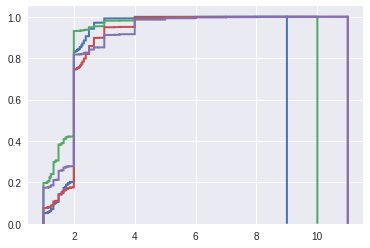

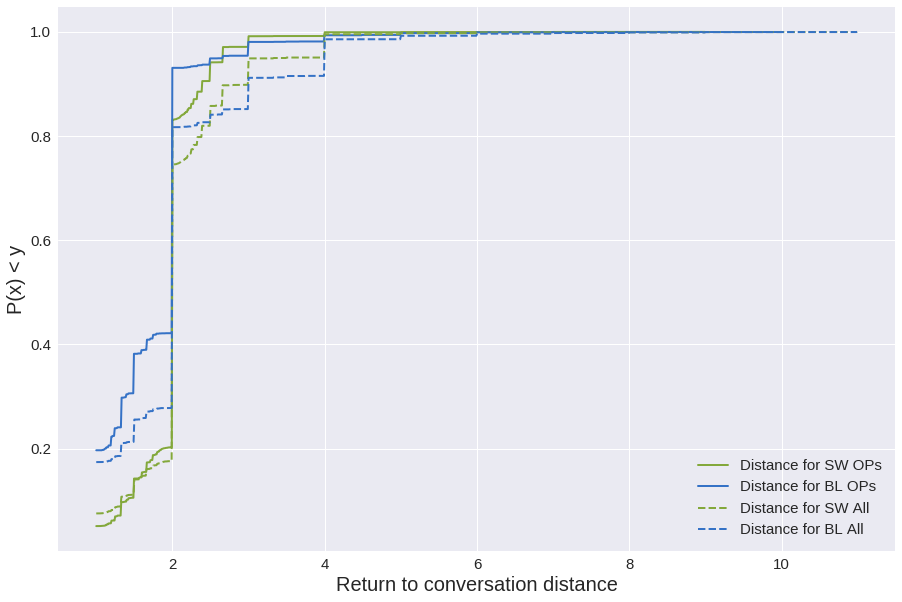

In [25]:
n1 , bins1 , patches1 = plt.hist([SW_opReturnFactor[k][0] for k in SW_opReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist([BL_opReturnFactor[k][0] for k in BL_opReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist([SW_ReturnFactor[k][0] for k in SW_ReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n4 , bins4 , patches4 = plt.hist([BL_ReturnFactor[k][0] for k in BL_ReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
ax.plot(bins3[:-1], n3, 'g--', linewidth=2)
ax.plot(bins4[:-1], n4, 'b--', linewidth=2)

# plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Return to conversation distance",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Distance for SW OPs','Distance for BL OPs','Distance for SW All','Distance for BL All'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 7 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

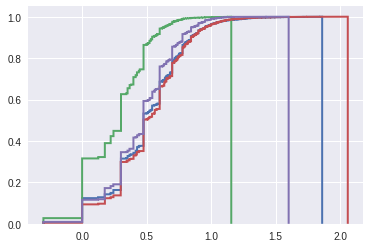

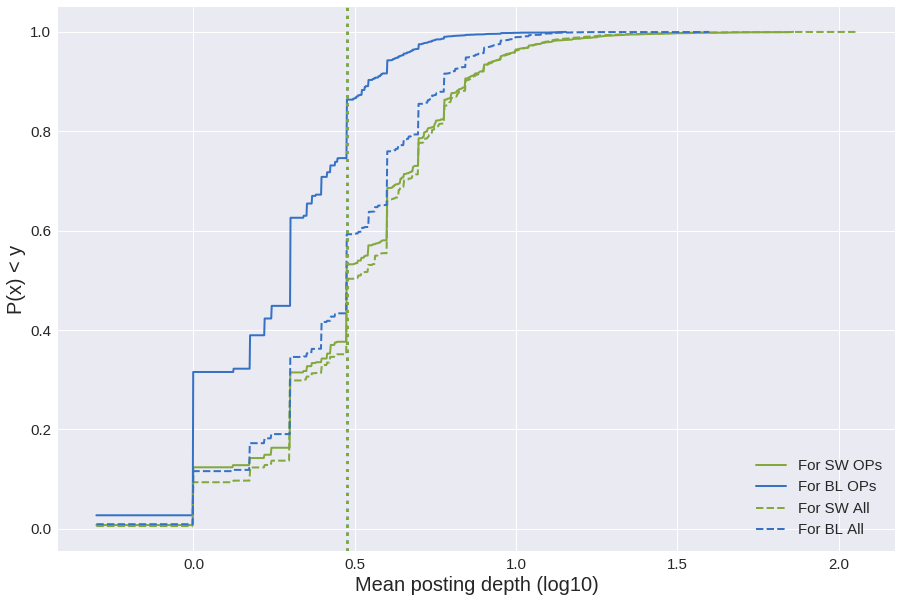

In [26]:
n1 , bins1 , patches1 = plt.hist(np.log10([SW_opReturnFactor[k][1]+1 for k in SW_opReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(np.log10([BL_opReturnFactor[k][1]+1 for k in BL_opReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(np.log10([SW_ReturnFactor[k][1]+1 for k in SW_ReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n4 , bins4 , patches4 = plt.hist(np.log10([BL_ReturnFactor[k][1]+1 for k in BL_ReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
ax.plot(bins3[:-1], n3, 'g--', linewidth=2)
ax.plot(bins4[:-1], n4, 'b--', linewidth=2)


ax.axvline(x=np.median(np.log10([BL_ReturnFactor[k][1]+1 for k in BL_ReturnFactor])), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(np.log10([SW_ReturnFactor[k][1]+1 for k in SW_ReturnFactor])), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')


# plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Mean posting depth (log10)",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['For SW OPs','For BL OPs','For SW All','For BL All'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [27]:
SW_branching = getBranchingFactor(ReplyGraphs_SW)

found a node with malformed data t3_g5rqg in graph g5u9u


In [28]:
BL_branching = getBranchingFactor(ReplyGraphs_BL)

In [29]:
Dep_branching = getBranchingFactor(ReplyGraphs_Dep)

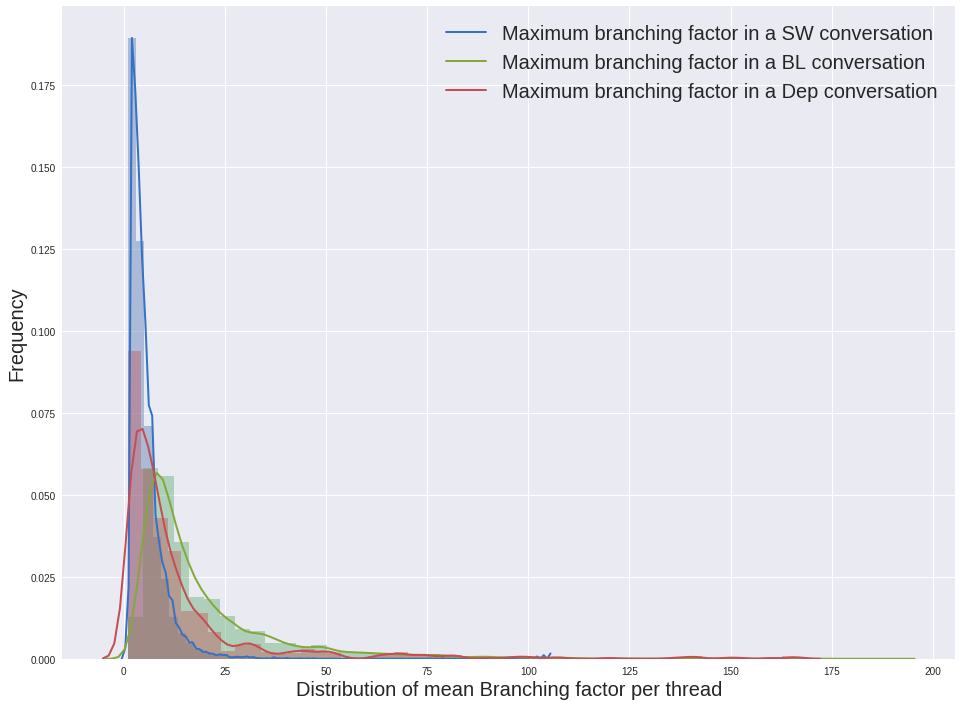

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot([SW_branching[k][2] for k in SW_branching],kde_kws={"color": "b", "lw": 2, "label": "Maximum branching factor in a SW conversation"})
sns.distplot([BL_branching[k][2] for k in BL_branching],kde_kws={"color": "g", "lw": 2, "label": "Maximum branching factor in a BL conversation"})
sns.distplot([Dep_branching[k][2] for k in Dep_branching],kde_kws={"color": "r", "lw": 2, "label": "Maximum branching factor in a Dep conversation"})
# ax.axvline(x=np.median(medTopicalSW), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
# ax.axvline(x=np.median(medTopicalBL), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of mean Branching factor per thread" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [31]:
BL_sorted_TA[-10:]

[(u'81x49o', 0.8702167451381684),
 (u'7zwkaq', 0.8802485346794129),
 (u'7zvu84', 0.8953911542892456),
 (u'819aaf', 0.9012245416641236),
 (u'825c7z', 0.9312152147293091),
 (u'7zmkq8', 0.9361676454544068),
 (u'80lsw5', 0.9406222879886628),
 (u'7z46vs', 0.9507737040519715),
 (u'814gcj', 0.9507791876792908),
 (u'80lwfx', 0.953444528579712)]

35


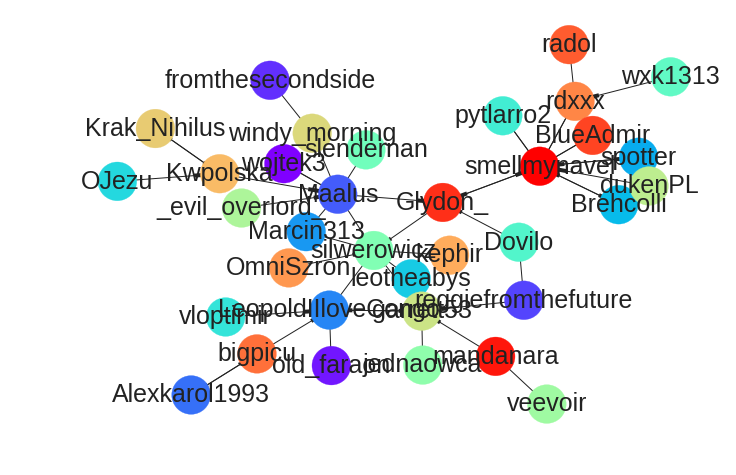

In [32]:
drawUserGraph(BL_Graphs[BL_sorted_TA[-10][0]])

2


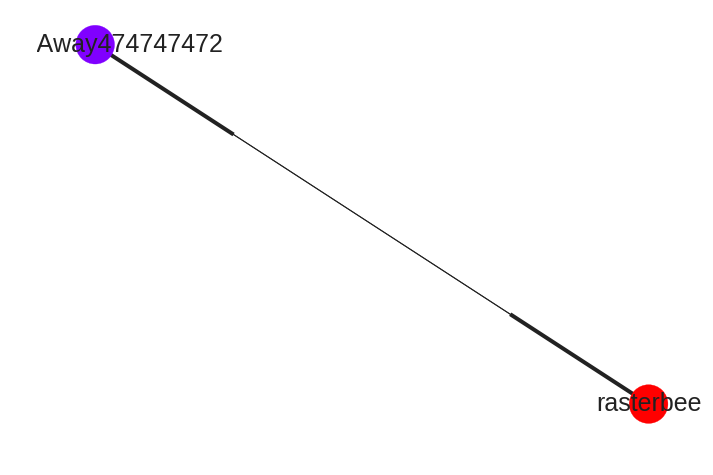

In [33]:
drawUserGraph(SW_Graphs[SW_sorted_TA[-15][0]])

In [34]:
len(BL_medCentralities) , len(SW_medCentralities)

(11070, 10527)

In [35]:
BL_medCentralities

[0.43315508021390375,
 0.3939393939393939,
 0.45,
 0.48333333333333334,
 0.22613065326633167,
 0.475,
 0.22655169828921723,
 0.4090909090909091,
 0.2916666666666667,
 0.3076923076923077,
 0.32120905952681655,
 0.34814814814814815,
 0.47368421052631576,
 0.2536231884057971,
 0.3865546218487395,
 0.42424242424242425,
 0.3696369636963696,
 0.2981871994080651,
 0.4772727272727273,
 0.3728813559322034,
 0.4507042253521127,
 0.2810810810810811,
 0.45454545454545453,
 0.375,
 0.42857142857142855,
 0.337664615716753,
 0.3958333333333333,
 0.37037037037037035,
 0.47058823529411764,
 0.24442750797589508,
 0.4642857142857143,
 0.2777777777777778,
 0.4107142857142857,
 0.3898305084745763,
 0.48684210526315785,
 0.1915750915750916,
 0.3958333333333333,
 0.25449101796407186,
 0.42857142857142855,
 0.424,
 0.4,
 0.39473684210526316,
 0.32,
 0.4525862068965517,
 0.3335526315789474,
 0.4358974358974359,
 0.4117647058823529,
 0.40551181102362205,
 0.3776223776223776,
 0.4107142857142857,
 0.483870967741

In [36]:
# medTopicalSW , TopicalSpreadSW = getTopicMetrics(SW_Graphs)

In [37]:
# len(medTopicalSW) , len(TopicalSpreadSW)

In [38]:
# medTopicalBL , TopicalSpreadBL = getTopicMetrics(BL_Graphs)

In [39]:
# len(medTopicalBL) , len(TopicalSpreadBL)

In [40]:
print len(SW_opCentralities) , len(BL_opCentralities) , len(Dep_opCentralities)

10527 11070 846


In [41]:
len(BL_medClusterings) , len(SW_medClusterings)

(11070, 10527)

In [42]:
topicAlignmentAll_BL = getTopicdist(ReplyGraphs_BL)

In [43]:
len(topicAlignmentAll_BL[0])

11070

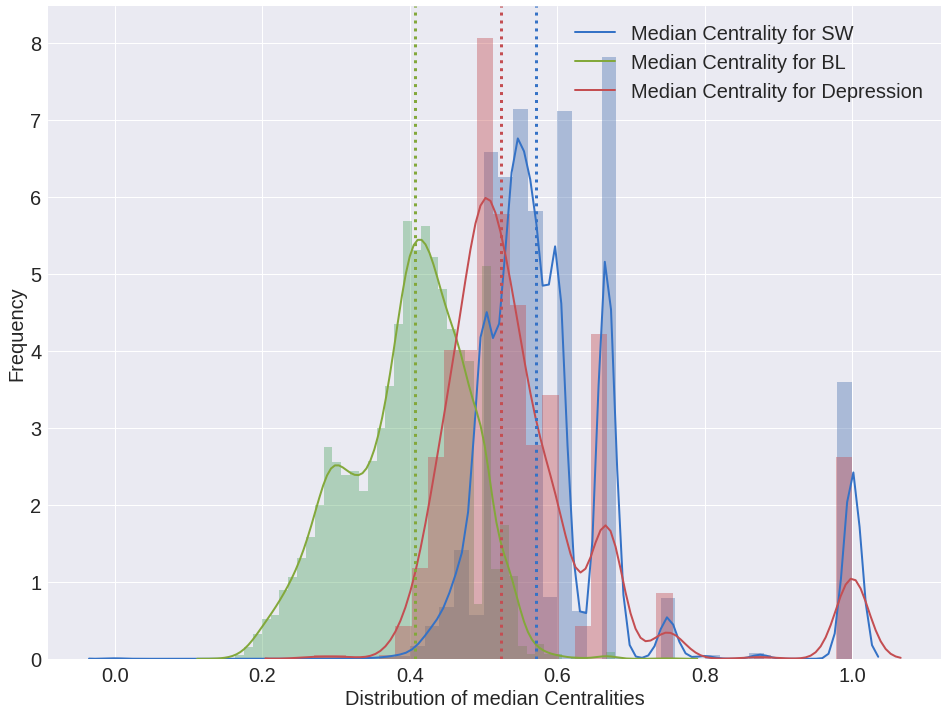

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_medCentralities,kde_kws={"color": "b", "lw": 2, "label": "Median Centrality for SW"})
sns.distplot(BL_medCentralities,kde_kws={"color": "g", "lw": 2, "label": "Median Centrality for BL"})
sns.distplot(Dep_medCentralities,kde_kws={"color": "r", "lw": 2, "label": "Median Centrality for Depression"})
ax.axvline(x=np.median(SW_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
ax.axvline(x=np.median(Dep_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'r', linestyle='dotted')
plt.xlabel("Distribution of median Centralities" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

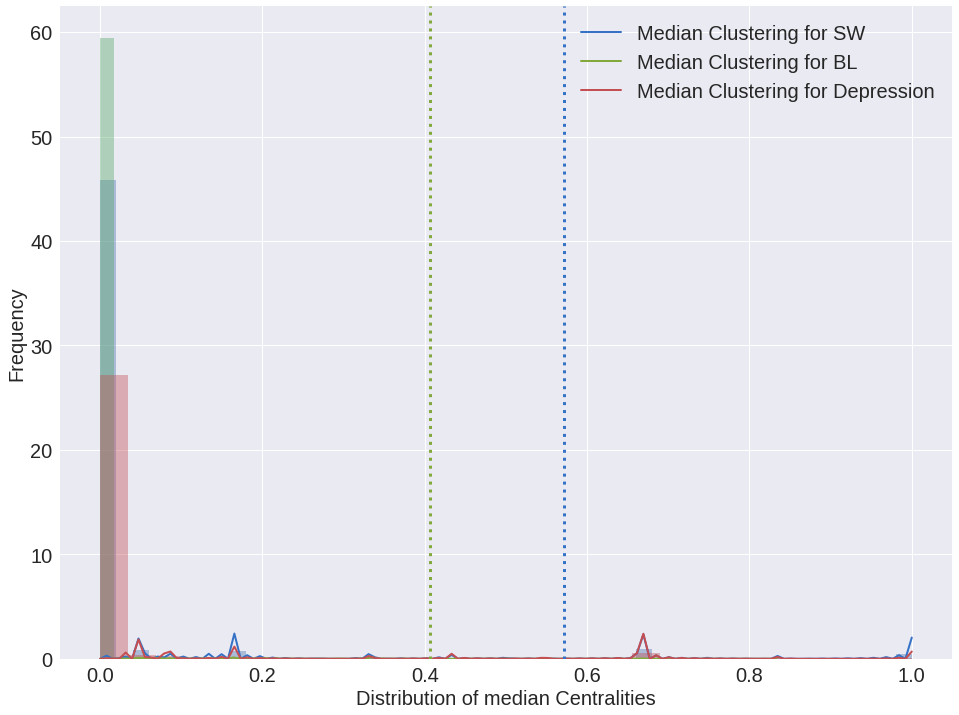

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_medClusterings,kde_kws={"color": "b", "lw": 2, "label": "Median Clustering for SW"})
sns.distplot(BL_medClusterings,kde_kws={"color": "g", "lw": 2, "label": "Median Clustering for BL"})
sns.distplot(Dep_medClusterings,kde_kws={"color": "r", "lw": 2, "label": "Median Clustering for Depression"})
ax.axvline(x=np.median(SW_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of median Centralities" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [46]:
nx.__version__

'1.11'

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

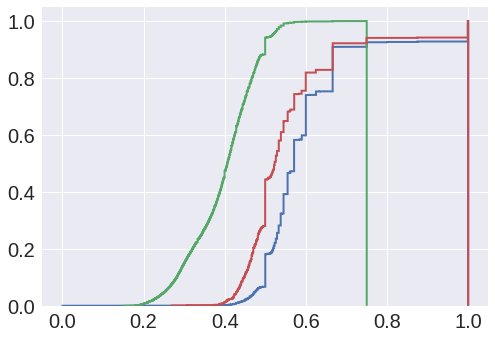

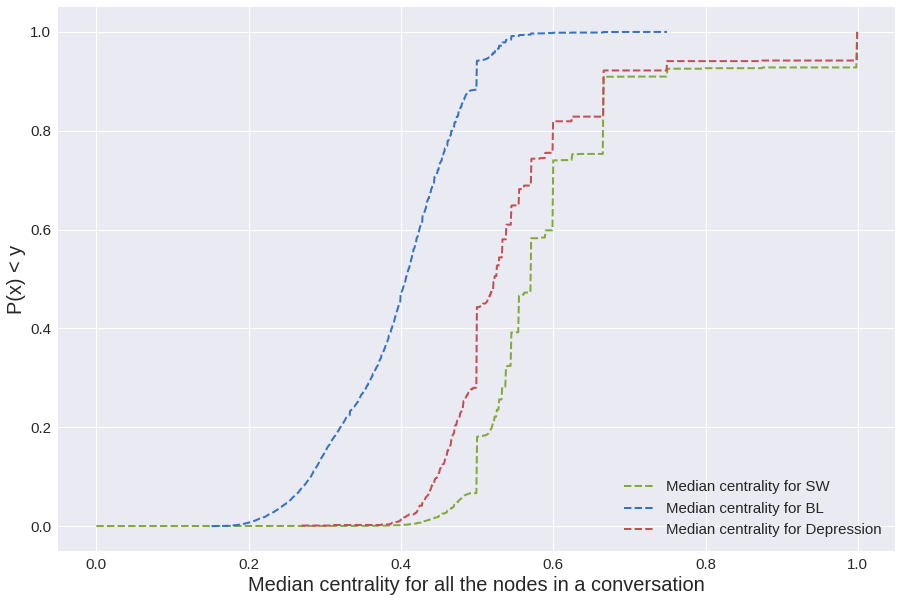

In [70]:
n1_all , bins1_all , patches1 = plt.hist(SW_medCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2_all , bins2_all , patches2 = plt.hist(BL_medCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3_all , bins3_all , patches3 = plt.hist(Dep_medCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1_all[:-1], n1_all, 'g--', linewidth=2)
ax.plot(bins2_all[:-1], n2_all, 'b--', linewidth=2)
ax.plot(bins3_all[:-1], n3_all, 'r--', linewidth=2)

plt.xlabel("Median centrality for all the nodes in a conversation",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Median centrality for SW','Median centrality for BL','Median centrality for Depression'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02]),
 <a list of 7 Text yticklabel objects>)

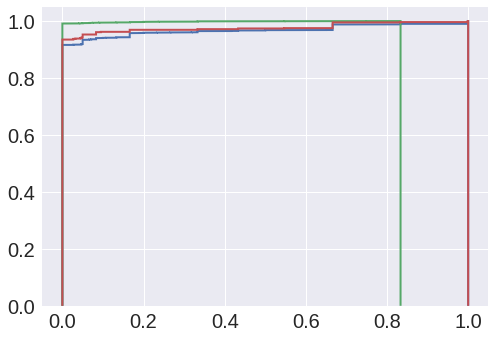

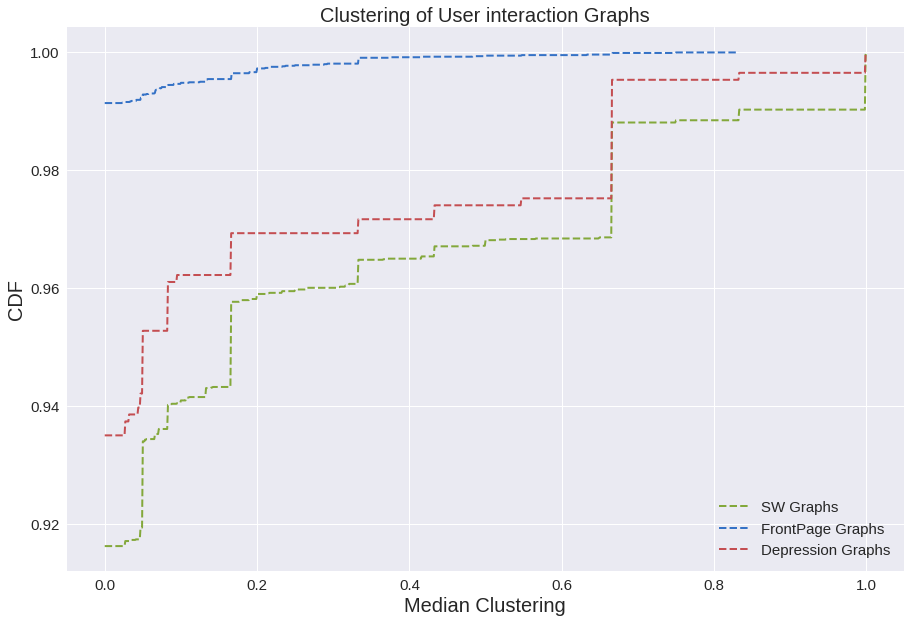

In [71]:
n1 , bins1 , patches1 = plt.hist(SW_medClusterings, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_medClusterings, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(Dep_medClusterings, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'g--', linewidth=2)
ax.plot(bins2[:-1], n2, 'b--', linewidth=2)
ax.plot(bins3[:-1], n3, 'r--', linewidth=2)

plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Median Clustering",fontsize = 20)
plt.ylabel("CDF",fontsize = 20)
plt.legend(['SW Graphs','FrontPage Graphs','Depression Graphs'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

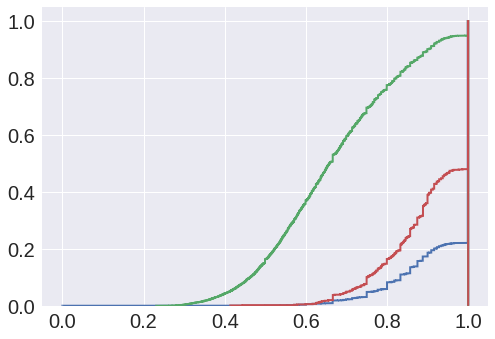

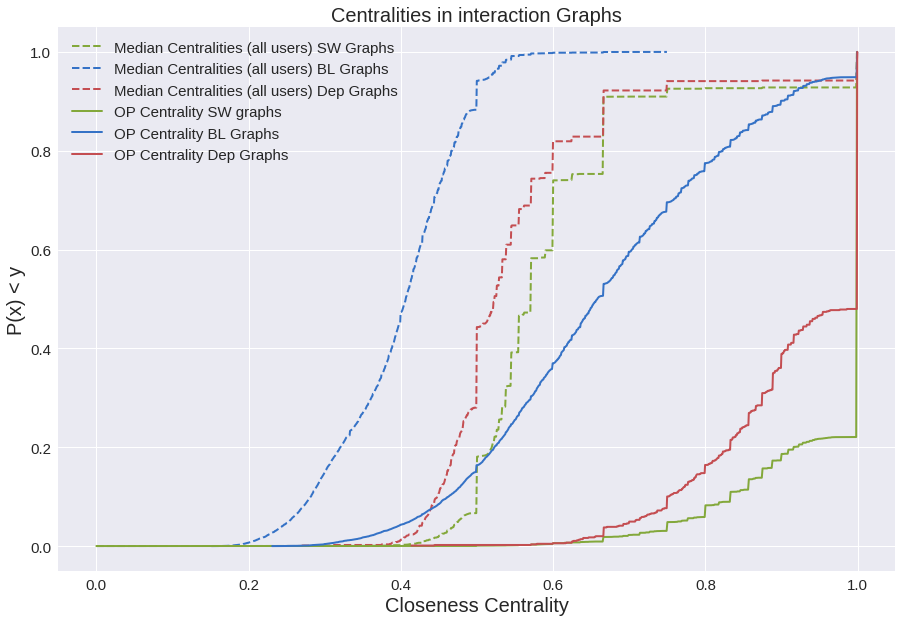

In [72]:
n1 , bins1 , patches1 = plt.hist(SW_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(Dep_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1_all[:-1], n1_all, 'g--', linewidth=2)
ax.plot(bins2_all[:-1], n2_all, 'b--', linewidth=2)
ax.plot(bins3_all[:-1], n3_all, 'r--', linewidth=2)

ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
ax.plot(bins3[:-1], n3, 'r', linewidth=2)

plt.title("Centralities in interaction Graphs", fontsize = 20)
plt.xlabel("Closeness Centrality",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Median Centralities (all users) SW Graphs','Median Centralities (all users) BL Graphs', 'Median Centralities (all users) Dep Graphs',
            'OP Centrality SW graphs','OP Centrality BL Graphs', 'OP Centrality Dep Graphs'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 7 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

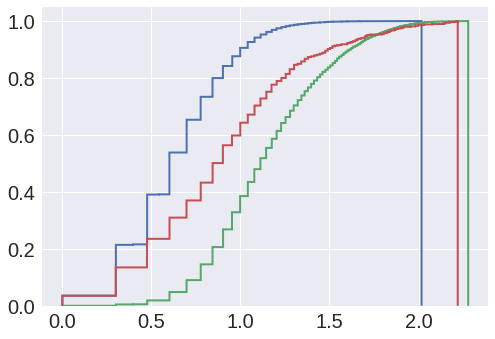

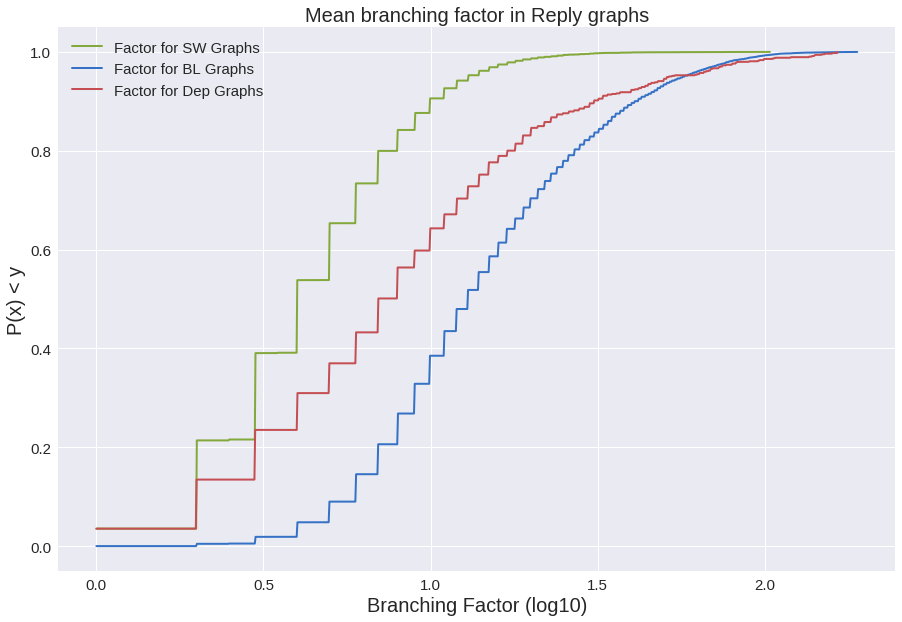

In [73]:
n1 , bins1 , patches1 = plt.hist(np.log10([SW_branching[k][2] for k in SW_branching]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(np.log10([BL_branching[k][2] for k in BL_branching]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(np.log10([Dep_branching[k][2] for k in Dep_branching]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
ax.plot(bins3[:-1], n3, 'r', linewidth=2)

plt.title("Mean branching factor in Reply graphs", fontsize = 20)
plt.xlabel("Branching Factor (log10)",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Factor for SW Graphs','Factor for BL Graphs','Factor for Dep Graphs'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [74]:
len(ReplyGraphs_SW), len(ReplyGraphs_BL), len(ReplyGraphs_Dep)

(10527, 11070, 846)

In [75]:
# commonKeys_BL= (set(ReplyGraphs_BL.keys()).intersection(BL_Graphs.keys()))
# len(commonKeys_BL)

In [76]:
# commonKeys_SW_all= (set(ReplyGraphs_SW.keys()).intersection(SW_Graphs.keys()))
# commonKeys_SW = random.sample(commonKeys_SW_all,len(commonKeys_BL))
# len(commonKeys_SW)

In [77]:
commonKeys_BL= [k for k in BL_Graphs if len(BL_Graphs[k].nodes()) >= 3]
print len(commonKeys_BL)

11070


In [78]:
commonKeys_SW= [k for k in SW_Graphs if len(SW_Graphs[k].nodes()) >= 3]
print len(commonKeys_SW)

9857


In [79]:
# |drawReplyGraph(ReplyGraphs_BL[ReplyGraphs_BL.keys()[11]])

In [80]:
ReplyGraphs_BL[ReplyGraphs_BL.keys()[11]].nodes(data=True)

[(u't1_duycd9j',
  {'affects': 25.77,
   'author': u'420throw666',
   'depth': 0,
   'downs': 0,
   'text': 'WHAT IN SWEET BABY RAYS NAME IS THIS FUCKERY',
   'time': 1519811905.0,
   'ups': 6}),
 (u't1_duyeurr',
  {'affects': 25.77,
   'author': u'frumps',
   'depth': 2,
   'downs': 0,
   'text': 'I wouldn\xe2\x80\x99t want to know what\xe2\x80\x99s been done to that tube. ',
   'time': 1519817964.0,
   'ups': 6}),
 (u't1_duybt52',
  {'affects': 25.77,
   'author': u'SullenTerror',
   'depth': 0,
   'downs': 0,
   'text': 'r/blackmagicfuckery',
   'time': 1519810501.0,
   'ups': 18}),
 (u't1_duyff65',
  {'affects': 25.77,
   'author': u'CrunchHardtack',
   'depth': 5,
   'downs': 0,
   'text': "I'm betting there will be no reply or he will have forgotten the name of this extremely memorable book.",
   'time': 1519819132.0,
   'ups': 5}),
 (u't1_duyfb2b',
  {'affects': 25.77,
   'author': u'ShiftyMctwizz',
   'depth': 0,
   'downs': 0,
   'text': 'Misread, expected /u/vernetroyer',
   

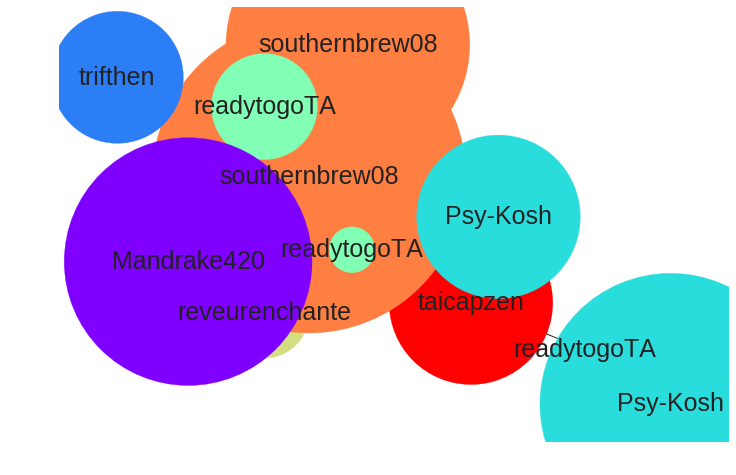

In [81]:
drawReplyGraph(ReplyGraphs_SW[SW_Graphs.keys()[10]])

5


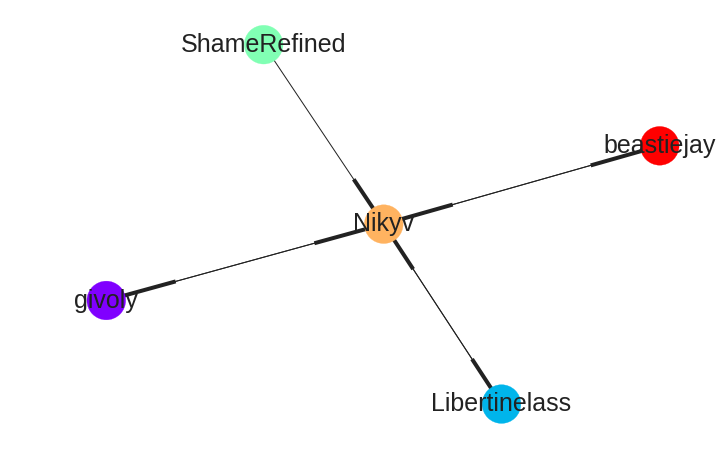

In [82]:
drawUserGraph(SW_Graphs[SW_Graphs.keys()[1011]])

In [83]:
print BL_Graphs[BL_Graphs.keys()[10]].edges(data=True)
print "---------------------------------------------"
print SW_Graphs[SW_Graphs.keys()[10]].edges(data=True)

[(u'bigde32', u'RepostSwat', {'timestamp': 1519772550.0, 'weight': 0.6274394273757935}), (u'bigde32', u'Pikachu1001000', {'timestamp': 1519766258.0, 'weight': -0.01435570120811458}), (u'Darkfire293', u'ConfusedRara', {'timestamp': 1519793099.0, 'weight': 0.3027638673782349}), (u'HeckinGoodDoggo', u'Pikachu1001000', {'timestamp': 1519856774.0, 'weight': 0.0637634258717299}), (u'RepostSwat', u'bigde32', {'timestamp': 1519771831.0, 'weight': 0.7168094396591187}), (u'cawkmonglingwitch', u'Pikachu1001000', {'timestamp': 1519777209.0, 'weight': -0.12951363325119014}), (u'tulpa_man', u'dukethedj', {'timestamp': 1519858881.0, 'weight': 0.1183868452906609}), (u'tulpa_man', u'Transhumaniste', {'timestamp': 1519855385.0, 'weight': 0.21252531111240391}), (u'tulpa_man', u'7aane', {'timestamp': 1520134891.0, 'weight': 0.17292385846376424}), (u'jboogie18', u'Pikachu1001000', {'timestamp': 1519810391.0, 'weight': 0.08142565861344342}), (u'ohlookahipster', u'bigde32', {'timestamp': 1519773449.0, 'weigh

In [84]:
[k[2]['timestamp'] for k in  BL_Graphs[BL_Graphs.keys()[1]].edges(data=True)]

[1519767002.0,
 1519737618.0,
 1519743103.0,
 1519759467.0,
 1519759268.0,
 1519741464.0,
 1519754961.0,
 1519763424.0,
 1519735576.0,
 1519744893.0,
 1519741112.0,
 1519738654.0,
 1519759406.0,
 1519766754.0,
 1519764482.0,
 1519766286.0,
 1519737984.0]

In [85]:
def getEdgeMetrics(graphs):
    EdgeWeight = []
    aggregateEdgeWeights = []
    varianceEdgeWeights = []
    for k in graphs:
        weights = [k[2]['weight'] for k in  graphs[k].edges(data=True)] 
        aggregateEdgeWeights+=weights
        meanWeight= np.median(weights)
        varWeight = np.var(weights)
        if np.isnan(meanWeight):
            print "Found Nan centrality"
            continue
        else:
            EdgeWeight.append(meanWeight)
        
        if np.isnan(varWeight):
            print "Found Nan Clustering"
            continue
        else:
            varianceEdgeWeights.append(varWeight)
        
    return EdgeWeight , varianceEdgeWeights 
    

In [86]:
SW_edgeWeights , SW_edgeVars = getEdgeMetrics(SW_Graphs)

In [87]:
BL_edgeWeights , BL_edgeVars = getEdgeMetrics(BL_Graphs)

In [88]:
Dep_edgeWeights , Dep_edgeVars = getEdgeMetrics(Dep_Graphs)

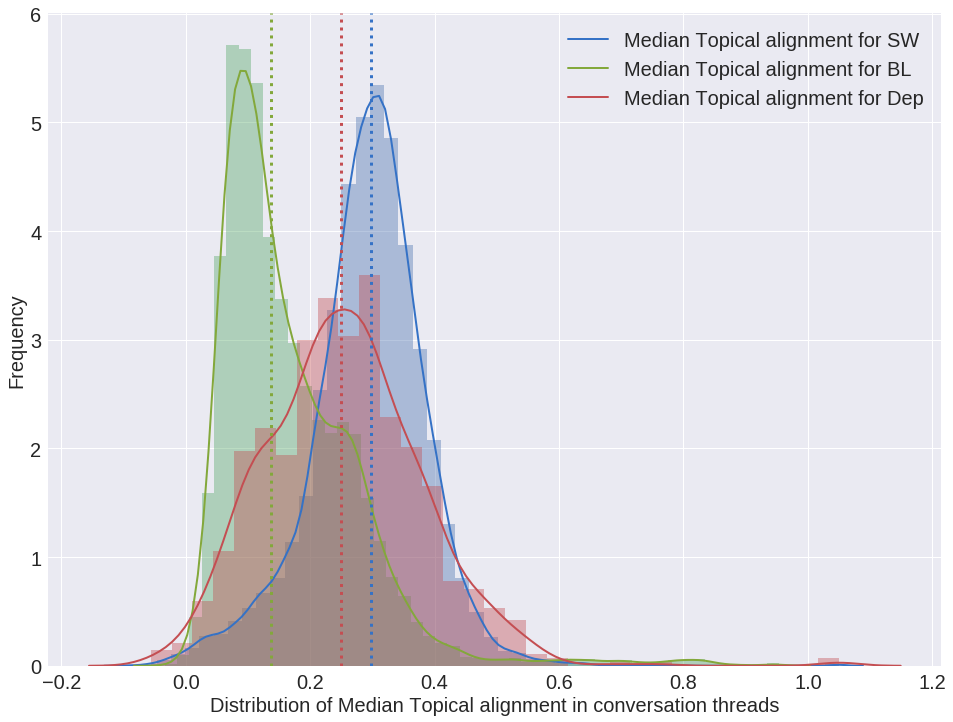

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_edgeWeights,kde_kws={"color": "b", "lw": 2, "label": "Median Topical alignment for SW"})
sns.distplot(BL_edgeWeights,kde_kws={"color": "g", "lw": 2, "label": "Median Topical alignment for BL"})
sns.distplot(Dep_edgeWeights,kde_kws={"color": "r", "lw": 2, "label": "Median Topical alignment for Dep"})
ax.axvline(x=np.median(SW_edgeWeights), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_edgeWeights), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
ax.axvline(x=np.median(Dep_edgeWeights), ymin=0, ymax=1, linewidth=3, color = 'r', linestyle='dotted')
plt.xlabel("Distribution of Median Topical alignment in conversation threads" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

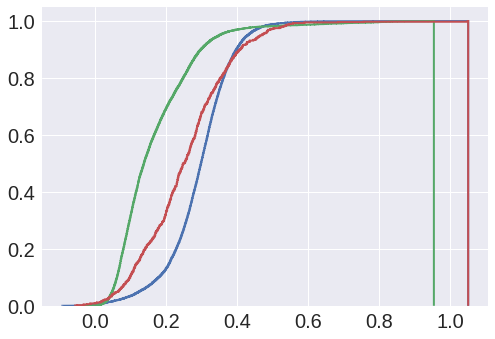

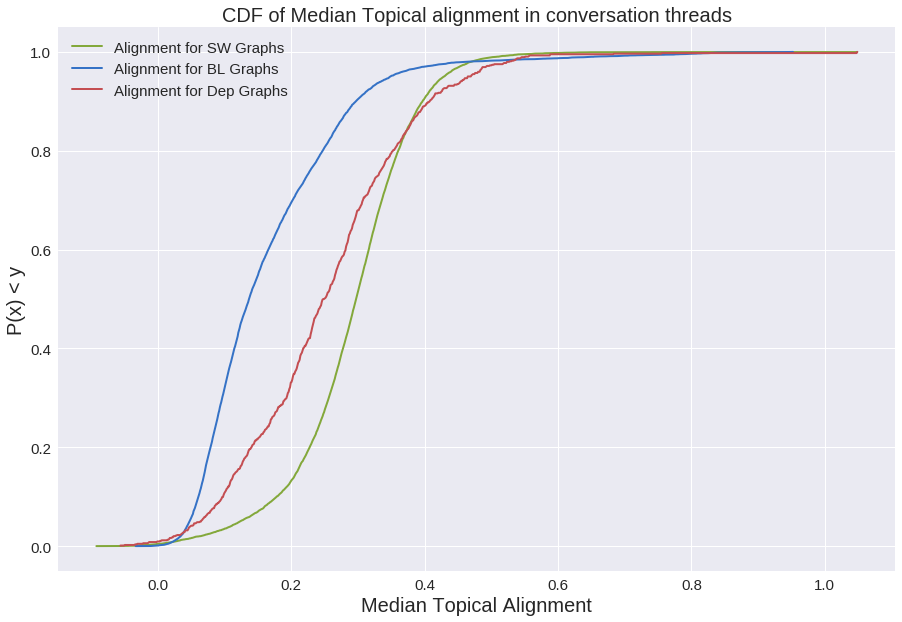

In [90]:
n1 , bins1 , patches1 = plt.hist(SW_edgeWeights, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_edgeWeights, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(Dep_edgeWeights, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
ax.plot(bins3[:-1], n3, 'r', linewidth=2)

plt.title("CDF of Median Topical alignment in conversation threads", fontsize = 20)
plt.xlabel("Median Topical Alignment",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Alignment for SW Graphs','Alignment for BL Graphs' , 'Alignment for Dep Graphs'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

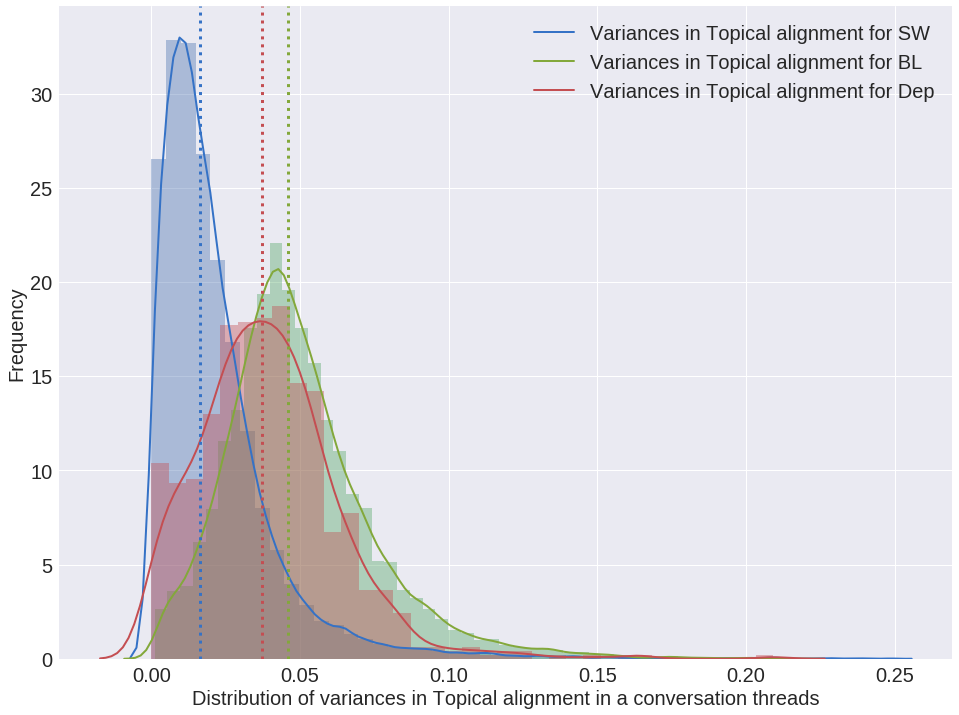

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_edgeVars,kde_kws={"color": "b", "lw": 2, "label": "Variances in Topical alignment for SW"})
sns.distplot(BL_edgeVars,kde_kws={"color": "g", "lw": 2, "label": "Variances in Topical alignment for BL"})
sns.distplot(Dep_edgeVars,kde_kws={"color": "r", "lw": 2, "label": "Variances in Topical alignment for Dep"})
ax.axvline(x=np.median(SW_edgeVars), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_edgeVars), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
ax.axvline(x=np.median(Dep_edgeVars), ymin=0, ymax=1, linewidth=3, color = 'r', linestyle='dotted')
plt.xlabel("Distribution of variances in Topical alignment in a conversation threads" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [92]:
ReplyGraphs_SW[ReplyGraphs_SW.keys()[101]].nodes(data=True)

[(u't1_c6xmw8s',
  {'affects': 1.0,
   'author': u'bluegerm',
   'depth': 2,
   'downs': 0,
   'text': 'why do you want to run away, are you having problems with your family?',
   'time': 1352263881.0,
   'ups': 2}),
 (u't1_c6xqd6v',
  {'affects': 79.41,
   'author': u'bluegerm',
   'depth': 4,
   'downs': 0,
   'text': "It sounds like you want to escape because you think it's an easy way out of your problems.  It isn't an easy way out, it's just a fantasy.  While you continue the fantasy you'll continue to avoid dealing with the problems with your life and let them build.  One day they may become big enough to make you feel you have no choice.  The real way out is to start facing your problems one by one and begin dealing with them, finding solutions.  You can do it.  You'll grow and change.  Accept the challenge of life and you'll begin to enjoy it.",
   'time': 1352286834.0,
   'ups': 1}),
 (u't1_c6xkqq2',
  {'affects': 25.77,
   'author': u'Kolkhoz',
   'depth': 0,
   'downs': 0,
 

In [93]:
# drawReplyGraph(ReplyGraphs_SW[ReplyGraphs_SW.keys()[101]])

In [94]:
class Tree:
    nxGraph = None
    path = []
    nodes = {}
    visited = []
    def __init__(self,G):
        self.nxGraph = G
        nodes = G.nodes(data=True)
        for n in nodes:
            self.nodes[n[0]] = n[1]
        
    def parseTree(self,node):
        if node != None:
            print self.nodes[node]
            self.visited.append(node)
            inEdges = self.nxGraph.in_edges(node , data=True)
            for k in inEdges:
                if k not in self.visited:
                    print k
                    self.parseTree(k[0])        
    
    def printPath(self):
        print self.path
    

def findLongChains(replyGraphs):
    chains = {}
    for k in replyGraphs:
        print "helllo"
        
        

In [95]:
BL_Graphs[BL_Graphs.keys()[160]].edges(data=True)

[(u'sketh_uwu',
  u'icouldberaff',
  {'timestamp': 1519862865.0, 'weight': 0.03806175217032437}),
 (u'icouldberaff',
  u'icouldberaff',
  {'timestamp': 1519858540.0, 'weight': -0.06477427184581752}),
 (u'icouldberaff',
  u'Unique_username91620',
  {'timestamp': 1519867871.0, 'weight': 0.77733074426651}),
 (u'icouldberaff',
  u'JaxonH',
  {'timestamp': 1519864004.0, 'weight': 0.549007523059845}),
 (u'icouldberaff',
  u'sketh_uwu',
  {'timestamp': 1519862894.0, 'weight': 0.5149914205074311}),
 (u'PerswAsian',
  u'icouldberaff',
  {'timestamp': 1519876445.0, 'weight': 0.2786637127399445}),
 (u'running_fridge',
  u'InuKaT',
  {'timestamp': 1519875382.0, 'weight': 0.3244487822055817}),
 (u'InuKaT',
  u'icouldberaff',
  {'timestamp': 1519873022.0, 'weight': 0.16962066590785985}),
 (u'InuKaT',
  u'Unique_username91620',
  {'timestamp': 1519884637.0, 'weight': 0.266143548488617}),
 (u'InuKaT',
  u'running_fridge',
  {'timestamp': 1519876277.0, 'weight': 0.33201994299888615}),
 (u'platinumpuss8

In [114]:
## this code is extension of Bataglij work on subquadratic triadic census. I am adding a feature to return the nodes in a triad along with vertex tagging.

# triads.py - functions for analyzing triads of a graph
#
# Copyright 2015 NetworkX developers.
# Copyright 2011 Reya Group <http://www.reyagroup.com>
# Copyright 2011 Alex Levenson <alex@isnotinvain.com>
# Copyright 2011 Diederik van Liere <diederik.vanliere@rotman.utoronto.ca>
#
# This file is part of NetworkX.
#
# NetworkX is distributed under a BSD license; see LICENSE.txt for more
# information.
"""Functions for analyzing triads of a graph."""
from __future__ import division

import networkx as nx
import operator

__author__ = '\n'.join(['Alex Levenson (alex@isnontinvain.com)',
                        'Diederik van Liere (diederik.vanliere@rotman.utoronto.ca)','Sagar Joglekar (sagar.joglekar@kcl.ac.uk'])

__all__ = ['my_triadic_census']

#: The names of each type of triad.
TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
               '030T', '030C', '201', '120D', '120U', '120C', '210', '300')

#: The integer codes representing each type of triad.
#:
#: Triads that are the same up to symmetry have the same code.
TRICODES = (1, 2, 2, 3, 2, 4, 6, 8, 2, 6, 5, 7, 3, 8, 7, 11, 2, 6, 4, 8, 5, 9,
            9, 13, 6, 10, 9, 14, 7, 14, 12, 15, 2, 5, 6, 7, 6, 9, 10, 14, 4, 9,
            9, 12, 8, 13, 14, 15, 3, 7, 8, 11, 7, 12, 14, 15, 8, 14, 13, 15,
            11, 15, 15, 16)

#: A dictionary mapping triad code to triad name.
TRICODE_TO_NAME = {i: TRIAD_NAMES[code - 1] for i, code in enumerate(TRICODES)}


def triad_graphs():
    """Returns a dictionary mapping triad name to triad graph."""

    def abc_graph():
        """Returns a directed graph on three nodes, named ``'a'``, ``'b'``, and
        ``'c'``.

        """
        G = nx.DiGraph()
        G.add_nodes_from('abc')
        return G

    tg = {name: abc_graph() for name in TRIAD_NAMES}
    tg['012'].add_edges_from([('a', 'b')])
    tg['102'].add_edges_from([('a', 'b'), ('b', 'a')])
    tg['102'].add_edges_from([('a', 'b'), ('b', 'a')])
    tg['021D'].add_edges_from([('b', 'a'), ('b', 'c')])
    tg['021U'].add_edges_from([('a', 'b'), ('c', 'b')])
    tg['021C'].add_edges_from([('a', 'b'), ('b', 'c')])
    tg['111D'].add_edges_from([('a', 'c'), ('c', 'a'), ('b', 'c')])
    tg['111U'].add_edges_from([('a', 'c'), ('c', 'a'), ('c', 'b')])
    tg['030T'].add_edges_from([('a', 'b'), ('c', 'b'), ('a', 'c')])
    tg['030C'].add_edges_from([('b', 'a'), ('c', 'b'), ('a', 'c')])
    tg['201'].add_edges_from([('a', 'b'), ('b', 'a'), ('a', 'c'), ('c', 'a')])
    tg['120D'].add_edges_from([('b', 'c'), ('b', 'a'), ('a', 'c'), ('c', 'a')])
    tg['120C'].add_edges_from([('a', 'b'), ('b', 'c'), ('a', 'c'), ('c', 'a')])
    tg['120U'].add_edges_from([('a', 'b'), ('c', 'b'), ('a', 'c'), ('c', 'a')])
    tg['210'].add_edges_from([('a', 'b'), ('b', 'c'), ('c', 'b'), ('a', 'c'),
                              ('c', 'a')])
    tg['300'].add_edges_from([('a', 'b'), ('b', 'a'), ('b', 'c'), ('c', 'b'),
                              ('a', 'c'), ('c', 'a')])
    return tg


def _tricode(G, v, u, w):
    """Returns the integer code of the given triad.

    This is some fancy magic that comes from Batagelj and Mrvar's paper. It
    treats each edge joining a pair of ``v``, ``u``, and ``w`` as a bit in
    the binary representation of an integer.

    """
    combos = ((v, u, 1), (u, v, 2), (v, w, 4), (w, v, 8), (u, w, 16),
              (w, u, 32))
    return sum(x for u, v, x in combos if v in G[u])


def my_triadic_census(G):
    """Determines the triadic census of a directed graph.

    The triadic census is a count of how many of the 16 possible types of
    triads are present in a directed graph.

    Parameters
    ----------
    G : digraph
       A NetworkX DiGraph

    Returns
    -------
    census : dict
       Dictionary with triad names as keys and number of occurrences as values.

    Notes
    -----
    This algorithm has complexity `O(m)` where `m` is the number of edges in
    the graph.

    References
    ----------
    .. [1] Vladimir Batagelj and Andrej Mrvar, A subquadratic triad census
        algorithm for large sparse networks with small maximum degree,
        University of Ljubljana,
        http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf

    """
    if not G.is_directed():
        raise nx.NetworkXError('Not defined for undirected graphs.')

    # Initialize the count for each triad to be zero.
    census = {name: 0 for name in TRIAD_NAMES}
    census_nodes = {name: [] for name in TRIAD_NAMES}
    taggedNodes = []
    n = len(G)
    # m = dict(zip(G, range(n)))
    m = {v: i for i, v in enumerate(G)}
    for v in G:
        vnbrs = set(G.pred[v]) | set(G.succ[v])
        for u in vnbrs:
            if m[u] <= m[v]:
                continue
            neighbors = (vnbrs | set(G.succ[u]) | set(G.pred[u])) - {u, v}
            compliment = [node for node in G.nodes() if node not in neighbors]
            # Calculate dyadic triads instead of counting them.
            # This is a problem for registering node members of this motif. This method of counting disallows recording the exact nodes that are part of the motif
            if v in G[u] and u in G[v]:
                census['102'] += n - len(neighbors) - 2
                for node in compliment:
                    if node not in [u,v]:
                        census_nodes['102'].append([u,v,node])
            else:
                census['012'] += n - len(neighbors) - 2
                for node in compliment:
                    if node not in [u,v]:
                        census_nodes['012'].append([u,v,node])
                    
            # Count connected triads.
            for w in neighbors:
                if m[u] < m[w] or (m[v] < m[w] and m[w] < m[u]
                                   and v not in G.pred[w]
                                   and v not in G.succ[w]):
                    code = _tricode(G, v, u, w)
                    census[TRICODE_TO_NAME[code]] += 1
                    census_nodes[TRICODE_TO_NAME[code]].append([v,u,w])

    # null triads = total number of possible triads - all found triads
    #
    # Use integer division here, since we know this formula guarantees an
    # integral value.
    census['003'] = ((n * (n - 1) * (n - 2)) // 6) - sum(census.values())
#     print("Calculation Done!!")
    return census, census_nodes




def getApexNode_201_111D_021U_021D_021C_111U(triad, G):
#     print triad
    degs = [G.degree(i) for i in triad]
    return triad[np.argmax(degs)]


def getThreadLifeTimes(graphs):
    lifetimes = []
    for g in graphs:
        G = graphs[g]
        ts =  nx.get_edge_attributes(G,'timestamp').values()
        ts.sort()
        lifetimes.append(float(ts[-1]) - float(ts[0]) + 1)
    return lifetimes 


def getMotifAges(G, MotifArray):
    ts =  nx.get_edge_attributes(G,'timestamp').values()
    ts.sort()
    ages = []
    for triad in MotifArray:
        triadAge = []
        for node in triad:
            edges = G[node]
            for n in triad:
                if n in edges:
                    age = (float(edges[n]['timestamp']) - float(ts[0]))/(float(ts[-1]) - float(ts[0]))
                    triadAge.append(age)
        ages.append(np.max(triadAge))
    return ages

def findEdgeOrder(edge,sortedEdges):
    count = 0
    for k in sortedEdges:
        if edge == k:
            return float(count)/float(len(sortedEdges))
        count +=1
    return None
            
        
def getMotifOrder(G, MotifArray):
    ts =  nx.get_edge_attributes(G,'timestamp')
    sorted_ts = sorted(ts.items(), key=operator.itemgetter(1))
    ages = []
    for triad in MotifArray:
        triadAge = []
        for node in triad:
            edges = G[node]
            for n in triad:
                if n in edges:
#                     print ((node,n),edges[n]['timestamp'])
                    order = findEdgeOrder(((node,n),edges[n]['timestamp']),sorted_ts)                    
                    triadAge.append(order)
        ages.append(np.max(triadAge))
    return ages

#--------------------------------------------------------------------------------------------------------------------
# Motif variant counters
#--------------------------------------------------------------------------------------------------------------------


def test111D(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 1 and indegs[op] == 0:
            return 0
        elif indegs[op] == 2 and outdegs[op] == 1:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test201(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if indegs[op] == 2 and outdegs[op] == 2:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test021U(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if indegs[op] == 2:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3

def test012(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 1 and indegs[op] == 0:
#             print "type a"
            return 0
        elif indegs[op] == 1 and outdegs[op] == 0:
#             print "type b"
            return 1
        else:
#             print "type c"
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test102(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 0 and indegs[op] == 0:
            return 0
        else:
            return 1
    else:
#         print "Op not in the motif, continuing"
        return 3
        
def test021D(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 0:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3

    
def test021C(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 1 and indegs[op] == 0:
            return 0
        elif indegs[op] == 1 and outdegs[op] == 1:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test111U(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 0 and indegs[op] == 1:
            return 0
        elif indegs[op] == 1 and outdegs[op] == 2:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
    
def test030T(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 0:
            return 0
        elif indegs[op] == 2 and outdegs[op] == 0:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    

def test120D(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 0:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3
    

def test120U(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 0 and indegs[op] == 2:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3
    

def test120C(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 1:
            return 0
        elif indegs[op] == 1 and outdegs[op] == 1:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test210(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 1:
            return 0
        elif indegs[op] == 2 and outdegs[op] == 1:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    

def getUnrolledMotifs(G , triads , motifString, opName):
    triadList = triads[motifString]
    Unrolled_Census = [0 , 0 , 0 , 0]
    if motifString in ['003' , '030C' , '300']:
        print "Motif is perfectly symmetric"
        Unrolled_Census = [len(triadList) , 0 , 0 , 0]
        return Unrolled_Census
    else:
        for nodes in triadList:
            triad_graph = G.subgraph(nodes)
            if motifString == '012':
                mo_type = test012(triad_graph,opName)
                
            elif motifString == '102':
                mo_type = test102(triad_graph,opName)
            
            elif motifString == '021D':
                mo_type = test021D(triad_graph,opName)
            
            elif motifString == '021U':
                mo_type = test021U(triad_graph,opName) 
            
            elif motifString == '021C':
                mo_type = test021C(triad_graph,opName)
                     
            elif motifString == '111D':
                mo_type = test111D(triad_graph,opName)
            
            elif motifString == '111U':
                mo_type = test111U(triad_graph,opName)
            
            elif motifString == '030T':
                mo_type = test030T(triad_graph,opName)
            
            elif motifString == '201':
                mo_type = test201(triad_graph,opName)
            
            elif motifString == '120D':
                mo_type = test120D(triad_graph,opName)

            elif motifString == '120U':
                mo_type = test120U(triad_graph,opName)
            
            elif motifString == '120C':
                mo_type = test120C(triad_graph,opName)
            
            elif motifString == '210':
                mo_type = test210(triad_graph,opName)
            
            else:
                print "Something is not right!!, received motif string %s"%motifString
                return Unrolled_Census
                
            Unrolled_Census[mo_type]+=1

        return Unrolled_Census
            

'Functions for analyzing triads of a graph.'

In [97]:
# sys.path.append("../Code/")
# import myTriadicCensus
G = BL_Graphs[BL_Graphs.keys()[160]]


22


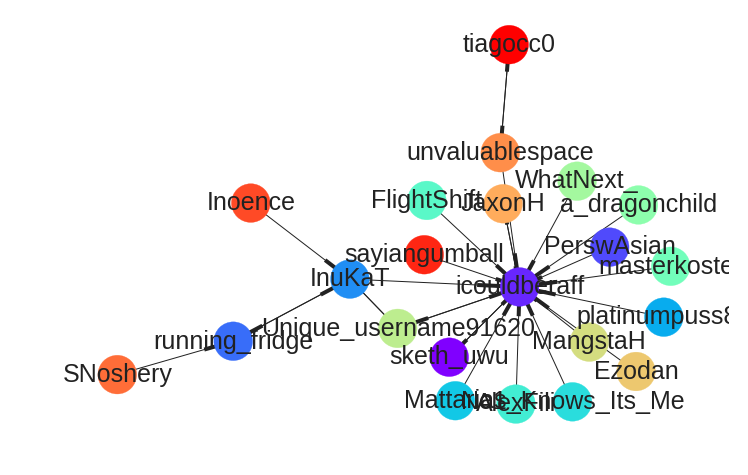

In [98]:
drawUserGraph(BL_Graphs[BL_Graphs.keys()[160]])

In [99]:
ts =  nx.get_edge_attributes(G,'timestamp')
sortedTs = sorted(ts, key=lambda X: ts[X])
import operator
sorted_x = sorted(ts.items(), key=operator.itemgetter(1))
print sorted_x[0][1]

1519858540.0


In [100]:
G['Unique_username91620']

{u'InuKaT': {'timestamp': 1519883322.0, 'weight': 0.377931821346283},
 u'icouldberaff': {'timestamp': 1519867750.0, 'weight': 0.12245265692472462}}

In [101]:
a =  nx.get_edge_attributes(G,'timestamp').values()
a.sort()
print a[-1] - a[0]

89758.0


In [102]:
keys, triads = my_triadic_census(G)
print keys
unrolledCensus = getUnrolledMotifs(G, triads , '111D' , FP_OpAuthors[BL_Graphs.keys()[160]])
print unrolledCensus

Calculation Done!!
{'201': 4, '021C': 1, '021D': 0, '210': 1, '120U': 0, '030C': 0, '003': 1244, '300': 0, '012': 89, '021U': 91, '120D': 0, '102': 64, '111U': 2, '030T': 0, '120C': 0, '111D': 44}
[0, 0, 41, 3]


In [103]:
print getMotifAges(G,triads['021U'])

[0.5642059760689855, 0.5642059760689855, 0.5642059760689855, 0.5642059760689855, 0.5642059760689855, 0.588437799416208, 0.5263709084427015, 0.16069876779785647, 0.16069876779785647, 0.16069876779785647, 0.588437799416208, 0.5263709084427015, 0.5263709084427015, 0.5263709084427015, 0.588437799416208, 0.5642059760689855, 0.19948082622161814, 0.365438178212527, 0.19948082622161814, 0.5263709084427015, 0.19948082622161814, 0.19948082622161814, 0.19948082622161814, 0.281334254328305, 0.19948082622161814, 1.0, 0.19948082622161814, 0.588437799416208, 0.0896187526460037, 0.11934312261859667, 0.588437799416208, 0.588437799416208, 0.588437799416208, 0.5642059760689855, 0.19562601662247375, 0.16134494975378239, 0.5263709084427015, 0.16134494975378239, 0.16134494975378239, 0.365438178212527, 0.16134494975378239, 0.281334254328305, 1.0, 0.16134494975378239, 0.588437799416208, 0.5642059760689855, 0.19562601662247375, 0.365438178212527, 0.16069876779785647, 0.5263709084427015, 0.09310590699436262, 0.

In [104]:
print getMotifOrder(G,triads['021U'])

[0.7931034482758621, 0.7931034482758621, 0.7931034482758621, 0.7931034482758621, 0.7931034482758621, 0.8275862068965517, 0.7586206896551724, 0.3793103448275862, 0.3793103448275862, 0.3793103448275862, 0.8275862068965517, 0.7586206896551724, 0.7586206896551724, 0.7586206896551724, 0.8275862068965517, 0.7931034482758621, 0.5517241379310345, 0.7241379310344828, 0.5517241379310345, 0.7586206896551724, 0.5517241379310345, 0.5517241379310345, 0.5517241379310345, 0.6551724137931034, 0.5517241379310345, 0.9655172413793104, 0.5517241379310345, 0.8275862068965517, 0.20689655172413793, 0.3448275862068966, 0.8275862068965517, 0.8275862068965517, 0.8275862068965517, 0.7931034482758621, 0.4827586206896552, 0.41379310344827586, 0.7586206896551724, 0.41379310344827586, 0.41379310344827586, 0.7241379310344828, 0.41379310344827586, 0.6551724137931034, 0.9655172413793104, 0.41379310344827586, 0.8275862068965517, 0.7931034482758621, 0.4827586206896552, 0.7241379310344828, 0.3793103448275862, 0.75862068965

In [126]:
def getTriadicCensus(graphs , keys=None):
    triadicCensus = {}
    triadNodes = {}
    if not keys:
        print "No selector dictionary passed"
        keys = graphs.keys()

    for g in keys:
        census, triads = my_triadic_census(graphs[g])
#         denom = len(graphs[g].nodes())+1
        
        triadicCensus[g] = {}
        triadicCensus[g] = census
        triadNodes[g] = {}
        triadNodes[g] = triads
#         for k in triadicCensus[g]:
#             triadicCensus[g][k]= float(triadicCensus[g][k])/float(denom)
    return triadicCensus , triadNodes
    

In [127]:
len(commonKeys_SW) , len(commonKeys_BL)

(9857, 11070)

In [129]:

triads_SW , triadNodes_SW = getTriadicCensus(SW_Graphs, commonKeys_SW)

In [130]:
# triadNodes_SW

In [ ]:
triads_BL , triadNodes_BL = getTriadicCensus(BL_Graphs,commonKeys_BL)

In [ ]:
triads_Dep , triadNodes_Dep = getTriadicCensus(Dep_Graphs,Dep_Graphs.keys())

In [ ]:
def doUnrolledAnalysis(Graphs, triadList,opList):
    triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
    unrolledMotifs = {}
    for k in triad_names:
        unrolledMotifs[k] = [0, 0 ,0 ,0]
    
    for g in Graphs:    
        G = Graphs[g]
        triads = triadList[g]
        op = opList[g]
        for k in triads:
            unrolled_motif_count = getUnrolledMotifs(G, triads , k ,op)
            for i in range(4):
                unrolledMotifs[k][i]+=unrolled_motif_count[i]
    return unrolledMotifs

def getMotifLifeTimes(Graphs, allTriadNodes):
    lifetimeArray= { '111D' : [] , '201' : [] , '021U' : [] , '021D' : [] , '021C' : [] , '111U' : [] }
    for k in allTriadNodes:
        for m in lifetimeArray.keys():
#             lifeTimes = getMotifOrder(Graphs[k], allTriadNodes[k][m])
            lifeTimes = getMotifAges(Graphs[k], allTriadNodes[k][m])
            lifetimeArray[m]+=lifeTimes
    return lifetimeArray

def getApexNodeStat(Graphs , allTriadNodes , opAuthors):
    apexNodeArray= { '111D' : [] , '201' : [] , '021U' : [] , '021D' : [] , '021C' : [] , '111U' : [] }
    for k in allTriadNodes:
        if k in opAuthors:
            for m in apexNodeArray.keys():
                count = 0.0
                frac = 0.0
                for triad in allTriadNodes[k][m]:
                    apexNode = getApexNode_201_111D_021U_021D_021C_111U(triad,Graphs[k])
                    if apexNode == opAuthors[k]:
                        count+=1
                if len(allTriadNodes[k][m]) > 0:
                    frac = count/float(len(allTriadNodes[k][m]))
                apexNodeArray[m].append(frac)
    return apexNodeArray

In [ ]:
unrolled_BL = doUnrolledAnalysis(BL_Graphs,triadNodes_BL,FP_OpAuthors)

In [ ]:
unrolled_SW = doUnrolledAnalysis(SW_Graphs,triadNodes_BL,FP_OpAuthors)

In [ ]:
SW_motif_ages = getMotifLifeTimes(SW_Graphs, triadNodes_SW)

In [ ]:
BL_motif_ages = getMotifLifeTimes(BL_Graphs, triadNodes_BL)

In [ ]:
Dep_motif_ages = getMotifLifeTimes(Dep_Graphs, triadNodes_Dep)

{'boxes': [<matplotlib.lines.Line2D at 0x7fabebb66290>,
 'caps': [<matplotlib.lines.Line2D at 0x7fabf49ff7d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fabf49379d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fabf49ffb10>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fabf484f3d0>,
  <matplotlib.lines.Line2D at 0x7fabf5725110>]}

([<matplotlib.axis.XTick at 0x7fac3abe3050>,
 <a list of 6 Text xticklabel objects>)

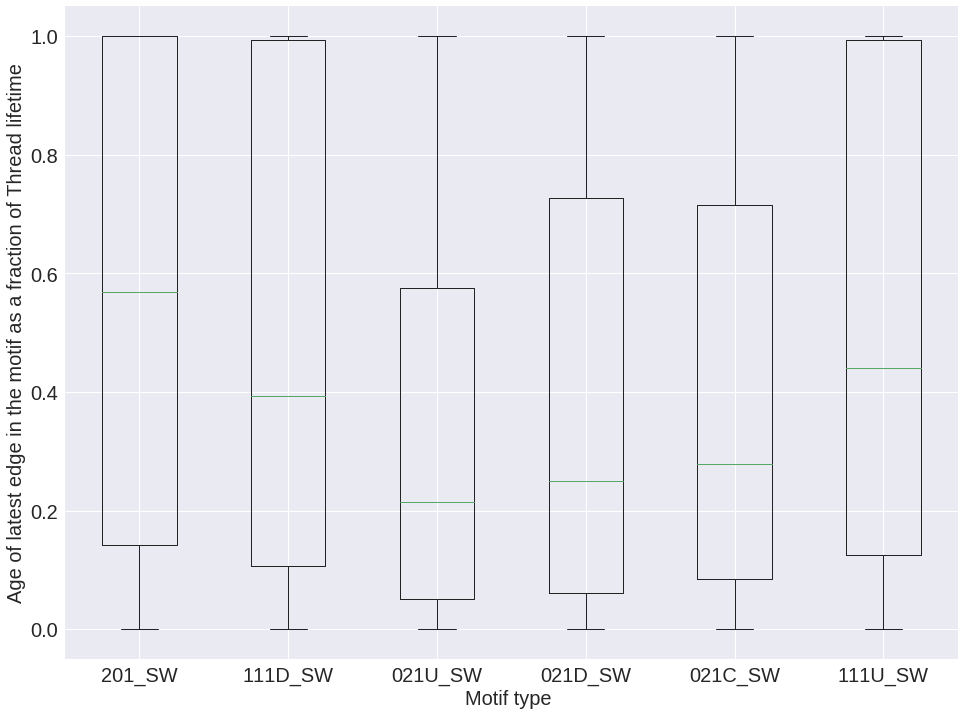

In [392]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
data = [SW_motif_ages['201'], SW_motif_ages['111D'], SW_motif_ages['021U'] , BL_motif_ages['201'], BL_motif_ages['111D'], BL_motif_ages['021U']]
data = [SW_motif_ages['201'], SW_motif_ages['111D'], SW_motif_ages['021U'] , SW_motif_ages['021D'] , SW_motif_ages['021C'] , SW_motif_ages['111U']]

# multiple box plots on one figure
plt.boxplot(data)
plt.xlabel("Motif type ",fontsize = 20)
# plt.ylabel("Rank of the latest message in motif, fraction of total messages",fontsize = 20)
plt.ylabel("Age of latest edge in the motif as a fraction of Thread lifetime",fontsize = 20)
# plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' ,'201_BL' , '111D_BL' , '021U_BL'])
plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' , '021D_SW' , '021C_SW' , '111U_SW' ])
plt.show()

In [393]:
SW_lifetimes = getThreadLifeTimes(SW_Graphs)
BL_lifetimes = getThreadLifeTimes(BL_Graphs)
Dep_lifetimes = getThreadLifeTimes(Dep_Graphs)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

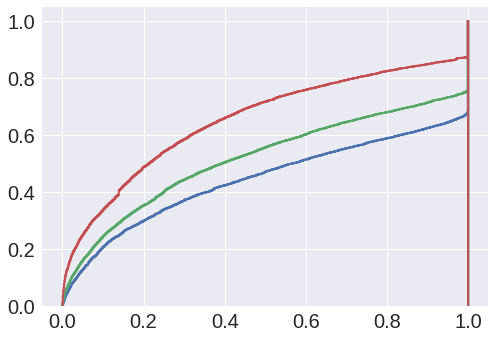

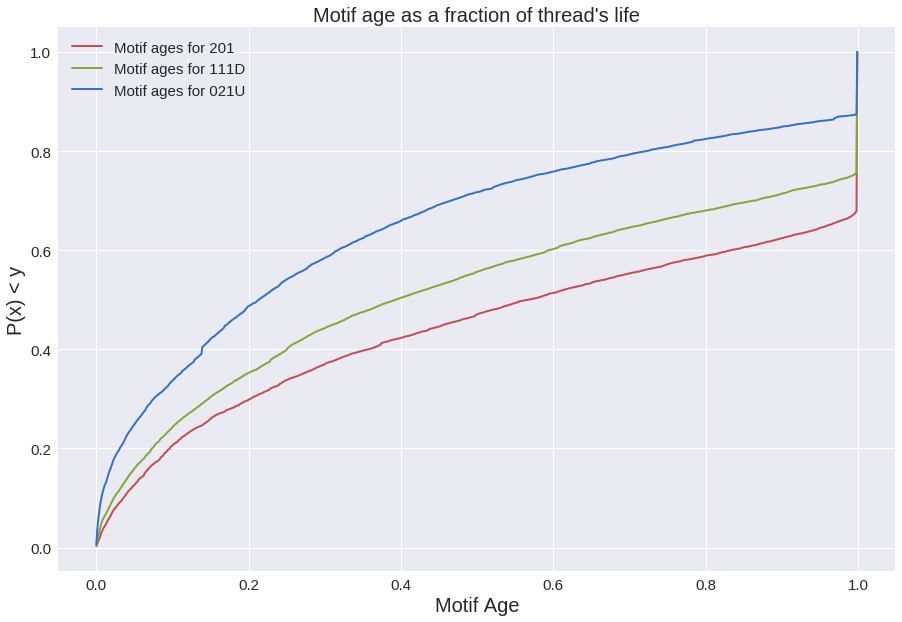

In [394]:
n1 , bins1 , patches1 = plt.hist(SW_motif_ages['201'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(SW_motif_ages['111D'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(SW_motif_ages['021U'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'r', linewidth=2)
ax.plot(bins2[:-1], n2, 'g', linewidth=2)
ax.plot(bins3[:-1], n3, 'b', linewidth=2)

plt.title("Motif age as a fraction of thread's life", fontsize = 20)
plt.xlabel("Motif Age",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Motif ages for 201','Motif ages for 111D' , 'Motif ages for 021U'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 11 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

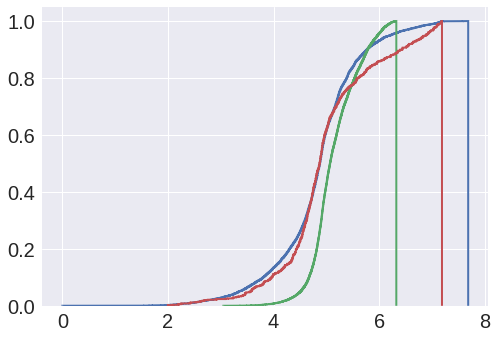

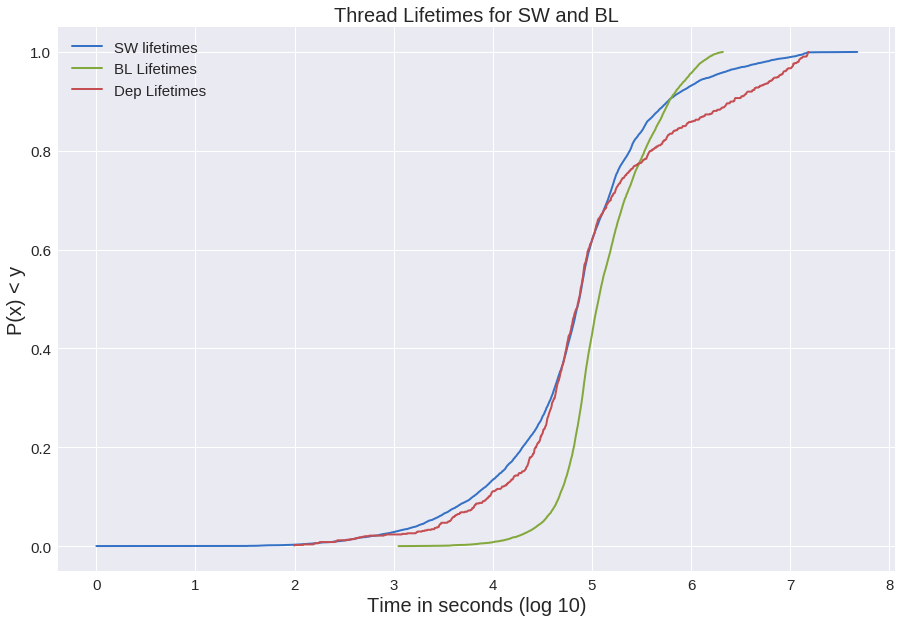

In [396]:
n1 , bins1 , patches1 = plt.hist(np.log10(SW_lifetimes), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(np.log10(BL_lifetimes), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3, bins3 , patches3 = plt.hist(np.log10(Dep_lifetimes), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'b', linewidth=2)
ax.plot(bins2[:-1], n2, 'g', linewidth=2)
ax.plot(bins3[:-1], n3, 'r', linewidth=2)

plt.title("Thread Lifetimes for SW and BL", fontsize = 20)
plt.xlabel("Time in seconds (log 10)",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['SW lifetimes' , 'BL Lifetimes' , 'Dep Lifetimes'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [397]:
ApexOpProportion = getApexNodeStat(SW_Graphs, triadNodes_SW,SW_OpAuthors)

ApexOpProportion_BL = getApexNodeStat(BL_Graphs, triadNodes_BL, FP_OpAuthors)

ApexOpProportion_Dep = getApexNodeStat(Dep_Graphs, triadNodes_Dep, Dep_OpAuthors)

{'boxes': [<matplotlib.lines.Line2D at 0x7fac01a23110>,
 'caps': [<matplotlib.lines.Line2D at 0x7fac1578d150>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac158c2510>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fac15802250>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fac156d3450>,
  <matplotlib.lines.Line2D at 0x7fac15d59c50>]}

([<matplotlib.axis.XTick at 0x7fac151951d0>,
 <a list of 3 Text xticklabel objects>)

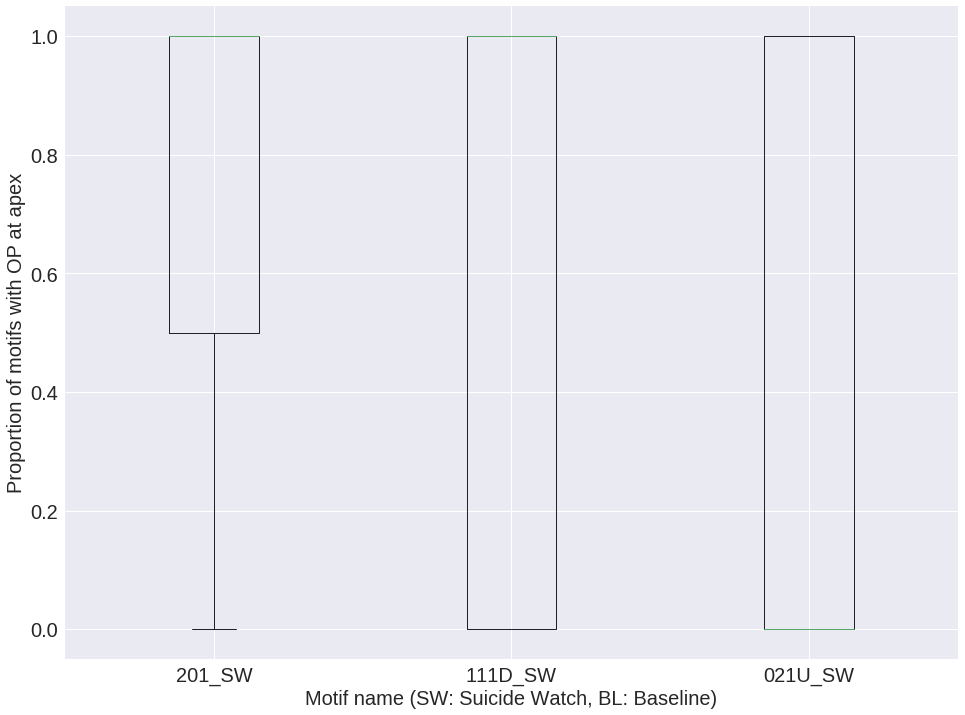

In [415]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
data = [ApexOpProportion['201'], ApexOpProportion['111D'], ApexOpProportion['021U'] ]
# multiple box plots on one figure
plt.boxplot(data)
plt.xlabel("Motif name (SW: Suicide Watch, BL: Baseline)",fontsize = 20)
plt.ylabel("Proportion of motifs with OP at apex",fontsize = 20)
plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' ,'201_BL' , '111D_BL' , '021U_BL'])
plt.show()

In [112]:
# print np.median(ApexOpProportion['201']),np.median(ApexOpProportion['111D']),np.median(ApexOpProportion['021U']),np.median(ApexOpProportion['021D']),np.median(ApexOpProportion['021C']),np.median(ApexOpProportion['111U']),
print np.mean(ApexOpProportion['201']),np.mean(ApexOpProportion['111D']),np.mean(ApexOpProportion['021U']),np.mean(ApexOpProportion['021D']),np.mean(ApexOpProportion['021C']),np.mean(ApexOpProportion['111U']),
print "------------------------"
print np.var(ApexOpProportion['201']),np.var(ApexOpProportion['111D']),np.var(ApexOpProportion['021U']),np.var(ApexOpProportion['021D']),np.var(ApexOpProportion['021C']),np.var(ApexOpProportion['111U']),

0.7494350873390275 0.5925965827462497 0.4606485444037224 0.0047283320216150995 0.09029017077197594 0.05346489823639309 ------------------------
0.18490301004975104 0.23689710455613874 0.24288353434652743 0.004378451866541723 0.07689005669818097 0.047203243359417876


In [398]:
# print np.median(ApexOpProportion_BL['201']),np.median(ApexOpProportion_BL['111D']),np.median(ApexOpProportion_BL['021U']),np.median(ApexOpProportion_BL['021D']),np.median(ApexOpProportion_BL['021C']),np.median(ApexOpProportion_BL['111U']),
print np.mean(ApexOpProportion_BL['201']),np.mean(ApexOpProportion_BL['111D']),np.mean(ApexOpProportion_BL['021U']),np.mean(ApexOpProportion_BL['021D']),np.mean(ApexOpProportion_BL['021C']),np.mean(ApexOpProportion_BL['111U']),
print "------------------------"
print np.var(ApexOpProportion_BL['201']),np.var(ApexOpProportion_BL['111D']),np.var(ApexOpProportion_BL['021U']),np.var(ApexOpProportion_BL['021D']),np.var(ApexOpProportion_BL['021C']),np.var(ApexOpProportion_BL['111U']),

0.3307841006635596 0.4907329151843582 0.8625404708230134 0.1032882509919546 0.5590298495303135 0.35662930255754816 ------------------------
0.19549923636927705 0.20876546598404463 0.053575515051116164 0.05901601944132339 0.10603351366837276 0.1446570222908343


{'boxes': [<matplotlib.lines.Line2D at 0x7fabf5a001d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fac006d2610>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac0084d650>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fac007825d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fac005eca10>,
  <matplotlib.lines.Line2D at 0x7fabffc22810>]}

([<matplotlib.axis.XTick at 0x7fac3c59f490>,
 <a list of 6 Text xticklabel objects>)

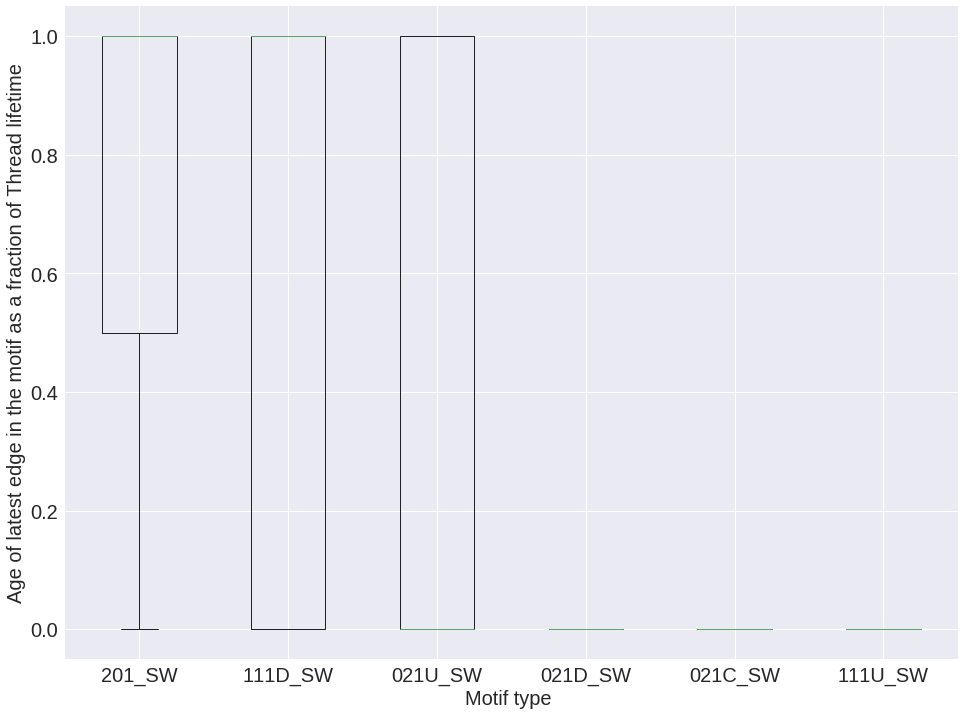

In [400]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
# data = [SW_motif_ages['201'], SW_motif_ages['111D'], SW_motif_ages['021U'] , BL_motif_ages['201'], BL_motif_ages['111D'], BL_motif_ages['021U']]
data = [ApexOpProportion['201'], ApexOpProportion['111D'], ApexOpProportion['021U'] , ApexOpProportion['021D'] , ApexOpProportion['021C'] , ApexOpProportion['111U']]
# multiple box plots on one figure
plt.boxplot(data)
plt.xlabel("Motif type ",fontsize = 20)
# plt.ylabel("Rank of the latest message in motif, fraction of total messages",fontsize = 20)
plt.ylabel("Age of latest edge in the motif as a fraction of Thread lifetime",fontsize = 20)
# plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' ,'201_BL' , '111D_BL' , '021U_BL'])
plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' , '021D_SW' , '021C_SW' , '111U_SW' ])
plt.show()

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 10 Text yticklabel objects>)

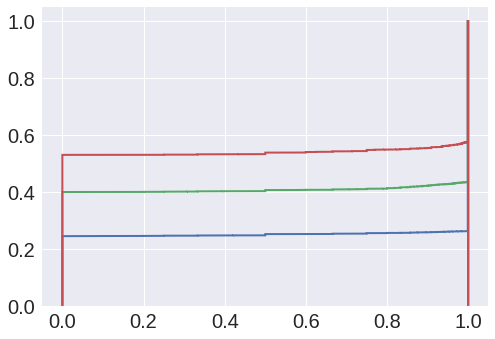

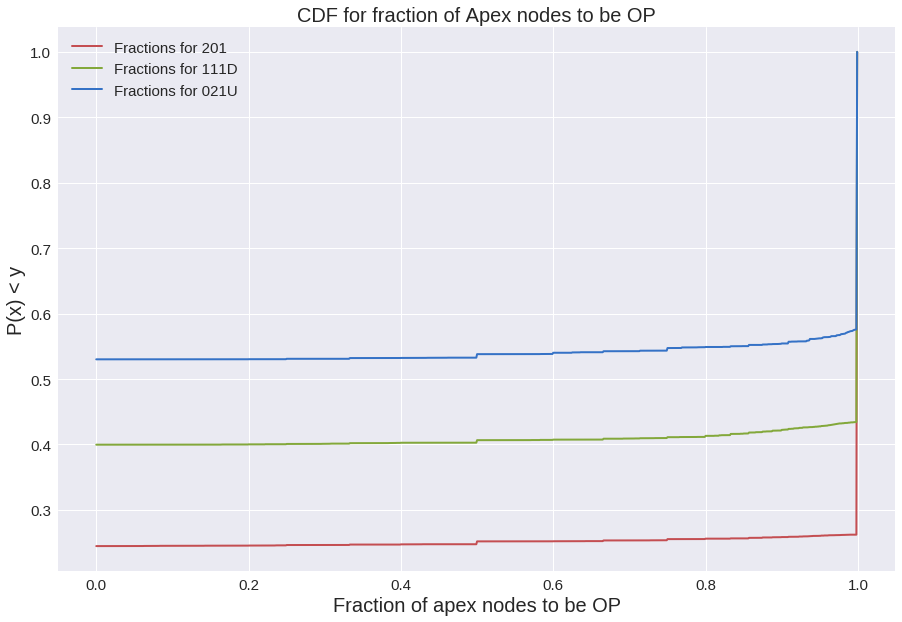

In [401]:
n1 , bins1 , patches1 = plt.hist(ApexOpProportion['201'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(ApexOpProportion['111D'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(ApexOpProportion['021U'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'r', linewidth=2)
ax.plot(bins2[:-1], n2, 'g', linewidth=2)
ax.plot(bins3[:-1], n3, 'b', linewidth=2)

plt.title("CDF for fraction of Apex nodes to be OP", fontsize = 20)
plt.xlabel("Fraction of apex nodes to be OP",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Fractions for 201','Fractions for 111D' , 'Fractions for 021U'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [402]:
print len(triads_SW), len(triads_BL)

9857 11070


In [117]:
# import json
# json.dump(triads_SW, open("SW_triadic_census_v2.json",'wb'))
# json.dump(triads_BL, open("BL_triadic_census_v2.json",'wb'))

In [118]:
# pkl.dump(file=open("SavedObjs/commonKeys_SW.pkl",'wb'),obj=commonKeys_SW)
# pkl.dump(file=open("SavedObjs/commonKeys_BL.pkl",'wb'),obj=commonKeys_BL)

# pkl.dump(file=open("SavedObjs/branching_BL.pkl",'wb'),obj=BL_branching)
# pkl.dump(file=open("SavedObjs/branching_SW.pkl",'wb'),obj=SW_branching)

In [403]:
triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
dim = triad_names[7]
SW_vals = [triads_SW[k][dim] for k in triads_SW]
BL_vals = [triads_BL[k][dim] for k in triads_BL]

In [404]:
# print SW_repVals

In [405]:
# SW_repVals = [repTriads_SW[k][dim] for k in repTriads_SW]
# BL_repVals = [repTriads_BL[k][dim] for k in repTriads_BL]

In [406]:
x , y = powerlaw.ccdf(SW_vals)
x2,y2 = powerlaw.ccdf(BL_vals)

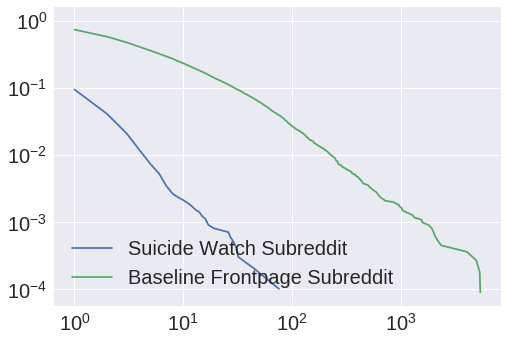

In [407]:
plt.loglog(x,y)
plt.loglog(x2,y2)
plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

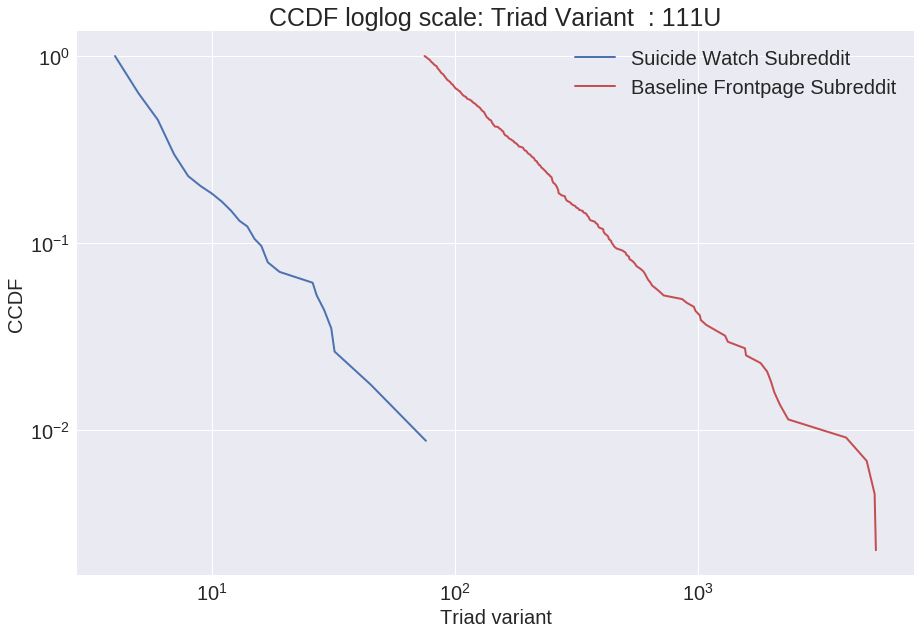

In [408]:
fit_SW = powerlaw.Fit(SW_vals)
fit_BL = powerlaw.Fit(BL_vals)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("CCDF loglog scale: Triad Variant  : " + dim, fontsize = 25)
plt.xlabel("Triad variant",fontsize = 20)
plt.ylabel("CCDF",fontsize = 20)
fig2=fit_SW.plot_ccdf(linewidth=2)
fit_BL.plot_ccdf(color='r', linewidth=2, ax=fig2)
plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

In [409]:
# fit_SW = powerlaw.Fit(SW_repVals)
# fit_BL = powerlaw.Fit(BL_repVals)

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.title("CCDF loglog scale: Triad Variant  : " + dim, fontsize = 25)
# plt.xlabel("Triad variant",fontsize = 20)
# plt.ylabel("CCDF",fontsize = 20)
# fig2=fit_SW.plot_ccdf(linewidth=2)
# fit_BL.plot_ccdf(color='r', linewidth=2, ax=fig2)
# plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

In [410]:
SW_sizes = {}
for k in commonKeys_SW:
    SW_sizes[k] = len(SW_Graphs[k].nodes())
BL_sizes = {}
for k in commonKeys_BL:
    BL_sizes[k] = len(BL_Graphs[k].nodes())

In [411]:
print len(SW_sizes), len(BL_sizes)

9857 11070


In [412]:
from scipy.stats import sem

def getSizeDict(graphs):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    return sizes 

def getRandomGraphCensus(n , p , graphCount ):
    graphs= {}
    for k in range(graphCount):
        g = nx.erdos_renyi_graph(n, p, seed=None, directed=True)
        graphs[str(k)] = g
    randomCensus = getTriadicCensus(graphs)
    return randomCensus, graphs

def getRandomRangedGraphCensus(nstart , nstop ,  p,  graphCountPernode ):
    graphs= {}
    for k in range(nstart,nstop):
        for j in range(graphCountPernode):
            g = nx.erdos_renyi_graph(k, p, seed=None, directed=True)
            graphs[str(k) + '_' + str(j)] = g
    randomCensus = getTriadicCensus(graphs)
    return randomCensus, graphs
    
    
def getNodeMotifSpread(graphs , listSizeSpread):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    census_graph = {}
    census_random = {}
    #iterate through graph size spread
    for s in listSizeSpread:
        print "Working with Size %d" %s
        subset_graphs = dict()
        for k in sizes:
            if sizes[k] == s:
                subset_graphs[k] = graphs[k]
        print "Working with %d Selected Graphs" %len(subset_graphs.keys())
        randomCensus = getRandomGraphCensus(len(subset_graphs.keys()),0.2,s)
        graphCensus = getTriadicCensus(subset_graphs)
        
        census_graph[s] = graphCensus
        census_random[s] = randomCensus
    return census_graph , census_random

def getNodeMotifBinnedSpread(graphs , startNodeCount , stopNodeCount, binSize):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    census_graph = {}
    #iterate through graph size spread
    binCount = 0
    for (start,stop) in zip(range(startNodeCount,stopNodeCount,binSize),range(startNodeCount+binSize,stopNodeCount+binSize,binSize)):
        print "Working with Size %d - %d"%(start,stop)
        subset_graphs = dict()
        for k in sizes:
            if (sizes[k] > start and sizes[k]<=stop):
                subset_graphs[k] = graphs[k]
        print "Working with %d Selected Graphs" %len(subset_graphs.keys())
        
        graphCensus = getTriadicCensus(subset_graphs)
        census_graph[binCount] = graphCensus
        binCount+=1
    return census_graph , binCount


def getCountsForMotifs(censusSpread,MotifKey):
    Counts = {}
    errors = {}
    for k in censusSpread:
        presence = 0
        count = [0]
        for g in censusSpread[k][0]:
#             print censusSpread[k][0].keys()
            if censusSpread[k][0][g][MotifKey] > 0:
#                 presence+=censusSpread[k][g][MotifKey]
                count.append(censusSpread[k][0][g][MotifKey])
#         Counts[k] = float(presence)/float(len(censusSpread[k].keys()))
        Counts[k] = np.mean(count)
        errors[k] = sem(count)
    return Counts , errors


def getAllMotifCounts(spread , motifKey , nodeNumbers):
    counts = []
    for k in spread[nodeNumbers][0]:
        if motifKey in spread[nodeNumbers][0][k]:
            counts.append(spread[nodeNumbers][0][k][motifKey])
    return counts


def calculateZscore(TargetSpread , baselineSpread):
    triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
    Zscores = {}
    for k in TargetSpread:
        for motifKey in triad_names:
            if motifKey not in Zscores:
                Zscores[motifKey] = []
            target = getAllMotifCounts(TargetSpread,motifKey,k)
            baseline = getAllMotifCounts(baselineSpread,motifKey,k)
            
            std = np.std(baseline)
            print std , len(baseline)
            
            z = (float(np.sum(target)) - float(np.sum(baseline)))/std
            Zscores[motifKey].append(z)
    return Zscores

In [413]:
# randomCensus, Randon_graphs = getRandomGraphCensus(30,0.3,100)
randomCensus, Random_graphs = getRandomRangedGraphCensus(3, 40,0.3,10)
    

No selector dictionary passed
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
C

In [195]:
randomCensus[1]

{'10_0': {'003': [],
  '012': [],
  '021C': [[0, 1, 2],
   [0, 1, 3],
   [0, 1, 6],
   [0, 2, 4],
   [0, 6, 7],
   [0, 6, 8],
   [0, 7, 8],
   [1, 9, 7],
   [1, 4, 3],
   [2, 8, 6],
   [2, 4, 3],
   [2, 4, 8],
   [2, 4, 9],
   [2, 7, 5],
   [3, 4, 7],
   [3, 6, 7],
   [3, 7, 5],
   [4, 9, 7],
   [5, 7, 8],
   [5, 7, 9],
   [6, 8, 7],
   [6, 9, 7]],
  '021D': [[0, 1, 4],
   [0, 2, 3],
   [0, 2, 6],
   [0, 7, 5],
   [2, 4, 7],
   [3, 4, 9],
   [3, 6, 8],
   [3, 6, 9],
   [6, 8, 9]],
  '021U': [[0, 1, 7],
   [0, 2, 8],
   [0, 3, 4],
   [1, 9, 6],
   [1, 4, 2],
   [2, 7, 3],
   [2, 7, 9],
   [3, 4, 6],
   [3, 7, 8],
   [3, 7, 9],
   [4, 9, 6],
   [7, 8, 9]],
  '030C': [[0, 2, 7], [0, 3, 7]],
  '030T': [[0, 3, 6], [1, 4, 9], [2, 7, 8]],
  '102': [],
  '111D': [[0, 9, 4]],
  '111U': [[0, 2, 9], [0, 3, 9]],
  '120C': [[0, 6, 9], [0, 7, 9]],
  '120D': [[0, 1, 9]],
  '120U': [],
  '201': [],
  '210': [],
  '300': []},
 '10_1': {'003': [],
  '012': [],
  '021C': [[0, 9, 7],
   [0, 3, 8],
   [0, 

In [139]:
# motifVals = [k['300'] for k in randomCensus]
SW_motifVals = [triads_SW[k]['300'] for k in  triads_SW if SW_sizes[k] == 30 ] 
BL_motifVals = [triads_BL[k]['300'] for k in  triads_BL if BL_sizes[k] == 30] 

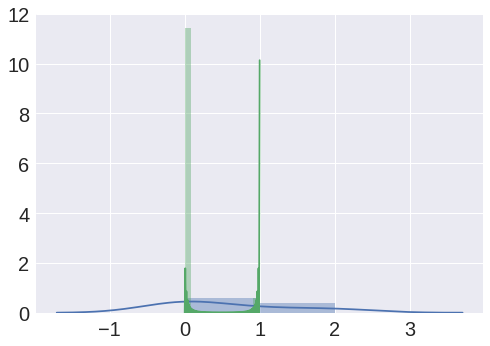

In [140]:
# sns.distplot(motifVals)
sns.distplot(SW_motifVals)
sns.distplot(BL_motifVals)

In [143]:
randomCensus[1]['9']

{'003': [],
 '012': [],
 '021C': [[0, 2, 4],
  [0, 2, 15],
  [0, 2, 16],
  [0, 3, 4],
  [0, 3, 5],
  [0, 3, 12],
  [0, 3, 14],
  [0, 3, 17],
  [0, 3, 18],
  [0, 3, 20],
  [0, 3, 26],
  [0, 4, 9],
  [0, 4, 20],
  [0, 4, 27],
  [0, 4, 29],
  [0, 6, 10],
  [0, 6, 17],
  [0, 6, 19],
  [0, 6, 24],
  [0, 6, 29],
  [0, 7, 9],
  [0, 7, 10],
  [0, 7, 14],
  [0, 7, 26],
  [0, 7, 28],
  [0, 7, 29],
  [0, 18, 5],
  [0, 18, 13],
  [0, 18, 24],
  [0, 18, 27],
  [0, 18, 28],
  [0, 21, 5],
  [0, 21, 24],
  [0, 21, 27],
  [0, 21, 28],
  [0, 22, 8],
  [0, 22, 12],
  [0, 22, 17],
  [0, 23, 5],
  [0, 23, 16],
  [0, 23, 28],
  [0, 24, 13],
  [0, 24, 19],
  [0, 24, 25],
  [0, 24, 27],
  [0, 28, 11],
  [0, 29, 9],
  [0, 29, 10],
  [0, 29, 20],
  [0, 29, 26],
  [1, 2, 3],
  [1, 2, 5],
  [1, 2, 6],
  [1, 2, 9],
  [1, 2, 10],
  [1, 2, 12],
  [1, 2, 20],
  [1, 2, 24],
  [1, 8, 7],
  [1, 8, 9],
  [1, 8, 18],
  [1, 9, 7],
  [1, 9, 11],
  [1, 9, 15],
  [1, 9, 19],
  [1, 9, 20],
  [1, 11, 12],
  [1, 11, 21],
  [1, 1

In [144]:
# SW_census_spread , R_census_spread = getNodeMotifSpread(SW_Graphs , [10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
SW_census_spread , bins = getNodeMotifBinnedSpread(SW_Graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 6596 Selected Graphs
No selector dictionary passed
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!


Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

In [145]:
# BL_census_spread , R_census_spread = getNodeMotifSpread(BL_Graphs , [10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
BL_census_spread , bins = getNodeMotifBinnedSpread(BL_Graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 107 Selected Graphs
No selector dictionary passed
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
C

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation 

In [197]:
R_census_spread , bins = getNodeMotifBinnedSpread(Random_graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 40 Selected Graphs
No selector dictionary passed
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculation Done!!
Working with Size 6 - 11
Working with 50 Selected Graphs
No selector dictionary passed
Calculation Done!!
Calculation Done!!
Calculation Done!!
Calculatio

In [202]:
R_census_spread[1]

({'10_0': {'003': 10,
   '012': 39,
   '021C': 15,
   '021D': 9,
   '021U': 10,
   '030C': 1,
   '030T': 5,
   '102': 11,
   '111D': 8,
   '111U': 4,
   '120C': 6,
   '120D': 1,
   '120U': 0,
   '201': 0,
   '210': 1,
   '300': 0},
  '10_1': {'003': 8,
   '012': 23,
   '021C': 18,
   '021D': 8,
   '021U': 21,
   '030C': 1,
   '030T': 17,
   '102': 3,
   '111D': 7,
   '111U': 6,
   '120C': 3,
   '120D': 4,
   '120U': 1,
   '201': 0,
   '210': 0,
   '300': 0},
  '10_2': {'003': 8,
   '012': 35,
   '021C': 13,
   '021D': 7,
   '021U': 5,
   '030C': 5,
   '030T': 9,
   '102': 10,
   '111D': 5,
   '111U': 6,
   '120C': 9,
   '120D': 3,
   '120U': 3,
   '201': 2,
   '210': 0,
   '300': 0},
  '10_3': {'003': 5,
   '012': 35,
   '021C': 21,
   '021D': 7,
   '021U': 10,
   '030C': 1,
   '030T': 11,
   '102': 7,
   '111D': 8,
   '111U': 6,
   '120C': 4,
   '120D': 0,
   '120U': 3,
   '201': 1,
   '210': 1,
   '300': 0},
  '10_4': {'003': 6,
   '012': 32,
   '021C': 17,
   '021D': 7,
   '021U': 5

In [176]:
BL_census_spread[1]

({u'800kmj': {'003': 65,
   '012': 27,
   '021C': 1,
   '021D': 0,
   '021U': 6,
   '030C': 0,
   '030T': 0,
   '102': 11,
   '111D': 4,
   '111U': 3,
   '120C': 0,
   '120D': 0,
   '120U': 0,
   '201': 3,
   '210': 0,
   '300': 0},
  u'7yt9ic': {'003': 93,
   '012': 54,
   '021C': 6,
   '021D': 0,
   '021U': 12,
   '030C': 0,
   '030T': 0,
   '102': 0,
   '111D': 0,
   '111U': 0,
   '120C': 0,
   '120D': 0,
   '120U': 0,
   '201': 0,
   '210': 0,
   '300': 0},
  u'7zkojd': {'003': 61,
   '012': 20,
   '021C': 1,
   '021D': 0,
   '021U': 15,
   '030C': 0,
   '030T': 0,
   '102': 18,
   '111D': 1,
   '111U': 3,
   '120C': 0,
   '120D': 0,
   '120U': 0,
   '201': 1,
   '210': 0,
   '300': 0},
  u'80njhn': {'003': 84,
   '012': 0,
   '021C': 0,
   '021D': 0,
   '021U': 3,
   '030C': 0,
   '030T': 0,
   '102': 0,
   '111D': 18,
   '111U': 0,
   '120C': 0,
   '120D': 0,
   '120U': 0,
   '201': 15,
   '210': 0,
   '300': 0},
  u'805b2k': {'003': 120,
   '012': 0,
   '021C': 0,
   '021D': 0,


In [162]:
def getSequentialValues(presenceCensus , spread):
    return [presenceCensus[k] for k in spread]

In [163]:
keys = nx.triadic_census(BL_Graphs[BL_Graphs.keys()[160]]).keys()
print keys

['201', '021C', '021D', '210', '120U', '030C', '003', '300', '012', '021U', '120D', '102', '111U', '030T', '120C', '111D']


In [164]:

triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']

In [270]:
dim = triad_names[6]
BL_presenceRatio , BL_errors = getCountsForMotifs(BL_census_spread,dim)
R_Ratio, R_errors = getCountsForMotifs(R_census_spread,dim)
SW_presenceRatio, SW_errors = getCountsForMotifs(SW_census_spread,dim)

In [271]:
print BL_presenceRatio
print R_Ratio
print SW_presenceRatio

{0: 3.289473684210526, 1: 7.879003558718861, 2: 13.477657935285054, 3: 19.36197440585009, 4: 26.96018202502844, 5: 34.67878787878788, 6: 40.359550561797754, 7: 54.850356294536816}
{0: 1.588235294117647, 1: 4.833333333333333, 2: 21.88235294117647, 3: 53.666666666666664, 4: 110.80392156862744, 5: 207.5686274509804, 6: 328.11764705882354, 7: 471.06451612903226}
{0: 3.025774877650897, 1: 9.188930503537245, 2: 22.49206349206349, 3: 38.22727272727273, 4: 48.163636363636364, 5: 85.96774193548387, 6: 104.63636363636364, 7: 166.9}


In [272]:
print getSequentialValues(SW_presenceRatio, range(bins))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
print getSequentialValues(BL_presenceRatio, range(bins))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
print getSequentialValues(R_Ratio,range(bins))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])

[3.025774877650897, 9.188930503537245, 22.49206349206349, 38.22727272727273, 48.163636363636364, 85.96774193548387, 104.63636363636364, 166.9]
[3.289473684210526, 7.879003558718861, 13.477657935285054, 19.36197440585009, 26.96018202502844, 34.67878787878788, 40.359550561797754, 54.850356294536816]
[1.588235294117647, 4.833333333333333, 21.88235294117647, 53.666666666666664, 110.80392156862744, 207.5686274509804, 328.11764705882354, 471.06451612903226]


In [273]:
def getXticks(startNodeCount , stopNodeCount, binSize):
    ticks = []
    for (start,stop) in zip(range(startNodeCount,stopNodeCount,binSize),range(startNodeCount+binSize,stopNodeCount+binSize,binSize)):
        ticks.append(str(start)+"-"+str(stop-1))
    return ticks

<Container object of 8 artists>

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7fab53b5a7d0>,
 <a list of 8 Text xticklabel objects>)

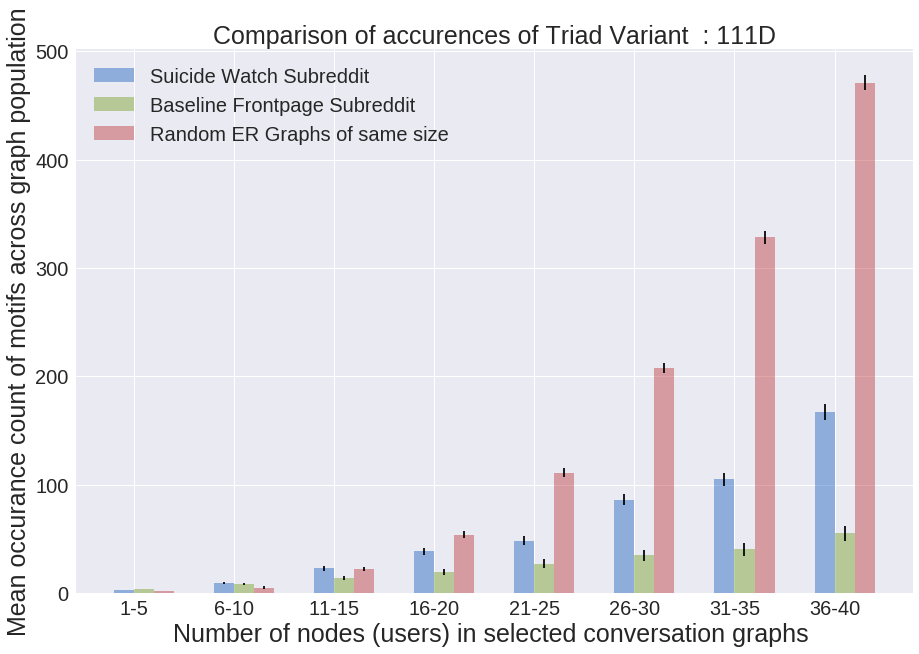

In [274]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of accurences of Triad Variant  : " + dim, fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across graph population",fontsize = 25)
x = np.arange(bins)
y1 = getSequentialValues(SW_presenceRatio, range(bins))
y2 = getSequentialValues(BL_presenceRatio, range(bins))
y3 = getSequentialValues(R_Ratio, range(bins))
ax.bar(x-0.1, y1 ,width=0.2, color='b',yerr = SW_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(x+0.1, y2 ,width=0.2, color='g',yerr = BL_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(x+0.3, y3 ,width=0.2, color='r',yerr = R_errors, align='center', alpha=0.5, ecolor='black', capsize=10)

# plt.plot(getSequentialValues(SW_presenceRatio, range(bins)))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30]))
# plt.errorbar(getSequentialValues(SW_presenceRatio, range(bins)), np.arange(1,40,3), yerr=SW_errors, fmt='.k')
# plt.plot(getSequentialValues(BL_presenceRatio, range(bins)))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30]))

plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit' , 'Random ER Graphs of same size'])

In [275]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.title("Comparison of accurences of Triad Variant  : " + dim, fontsize = 25)
# plt.xlabel("Number of Nodes in Selected Graphs ",fontsize = 25)
# plt.ylabel("Fraction of Graphs with motif present",fontsize = 25)
# plt.xticks(np.arange(8),[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# SW_result = getSequentialValues(SW_presenceRatio,[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# BL_result = getSequentialValues(BL_presenceRatio,[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# plt.plot([SW_result[i]/BL_result[i] for i in range(len(BL_result))])
# plt.legend(['Ratio of Motif foound in SW to those in BL'])

In [252]:
triads = nx.triads.triad_graphs()

In [263]:
Zscores_SW = calculateZscore(SW_census_spread,R_census_spread)
Zscores_BL = calculateZscore(BL_census_spread,R_census_spread)

1.2881673027988252 40
2.344008319097865 40
1.0650704202070396 40
0.7399324293474372 40
0.6959705453537527 40
1.3872184399005083 40
1.0096410253154335 40
0.9886859966642594 40
0.9996874511566103 40
0.30000000000000004 40
0.3570714214271425 40
0.4943429983321298 40
0.5567764362830022 40
0.7310095758606723 40
0.21794494717703367 40
0.15612494995995996 40
8.840814442120138 50
17.636428209816184 50
3.3207830401879614 50
3.694103409489237 50
4.5426424028311985 50
6.983867123592773 50
3.691937160895348 50
3.735719475549523 50
4.438062640387132 50
1.5879546593023368 50
1.2489995996796797 50
1.0583005244258363 50
1.42 50
2.2274649267721367 50
0.72691127381545 50
0.23748684174075835 50
20.960305341287373 50
38.55266008980444 50
15.169561628471667 50
7.977693902375548 50
9.614572273377533 50
16.82451782370003 50
10.206742869299687 50
10.987429180659142 50
9.424415101214505 50
3.8176432520600976 50
3.572338169882577 50
3.2511536414017717 50
3.1892945928527836 50
5.018206851057457 50
3.549704213029

In [261]:
Zscores

{'003': [12930.773792976288,
  14674.666101111798,
  7599.173647830888,
  3513.7632449045714,
  1367.3704883589205,
  1042.2896907235236,
  207.85484194757305,
  417.20683616410804],
 '012': [793.085922457592,
  807.7032282574902,
  206.98960801696728,
  -60.19377469120757,
  -181.36607397667674,
  -294.56030311859143,
  -363.1205686325387,
  -400.07878580372994],
 '021C': [100.20051348940338,
  62.715969855777516,
  -111.50393845803731,
  -169.79101923390377,
  -239.99457308310045,
  -279.0941830450644,
  -326.5648025125427,
  -292.4796344845201],
 '021D': [-5.405899027195887,
  -57.659457895210984,
  -139.89005013938734,
  -170.84310336556692,
  -218.01417765598686,
  -276.0836755385893,
  -323.42432078246435,
  -272.14926858265],
 '021U': [3606.47446469764,
  5664.10421915751,
  2231.4045170168924,
  494.40675032086307,
  90.35249604458411,
  -120.29096974501888,
  -253.7667211428406,
  -260.2959072059971],
 '030C': [9.999999999999998,
  -34.63574962786664,
  -86.96464757958836,
  -

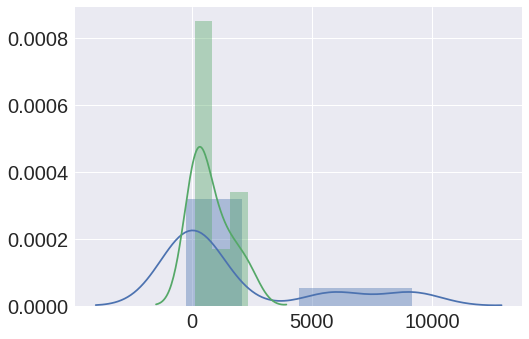

In [266]:
sns.distplot([Zscores_SW['111D']])
sns.distplot([Zscores_BL['111D']])

In [268]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# pos = graphviz_layout(triads[triad_names[6]], prog='neato')
# nx.draw(triads[triad_names[6]], pos=pos ,node_size=1500)